In [4]:
### IMPORT SCIENTIFIC LIBRARIES ###
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.optimize import curve_fit
import lmfit as lm
from tqdm import tqdm
from contextlib import redirect_stdout
import io


import matplotlib.pyplot as plt
plt.rcParams['font.size'], plt.rcParams['axes.labelsize'] = 14, 18
import sys, importlib

import sys
sys.path.append('./XPCSlibrary/')

import ID10_tools as ID10
from ID10_tools import Nx, Ny, Npx
importlib.reload(ID10)
ID10.set_version('v2')

import XPCS_tools as XPCS
from XPCS_tools import E2lambda, lambda2E, theta2Q, Q2theta, decorrelation_f
importlib.reload(XPCS)
XPCS.set_beamline('ID10')

import COSMICRAY_tools as COSMIC
importlib.reload(COSMIC)
COSMIC.set_beamline('ID10')

### EXPERIMENTAL VARIABLES ###
XPCS.set_expvar(Nx//2, Ny//2, 5)
ID10.Nfmax_dense_file = 2000
ID10.Nfmax_sparse_file = 5000

from folder_paths import *

In [ ]:
np.lin

AttributeError: module 'numpy' has no attribute 'linespace'

## Load masks

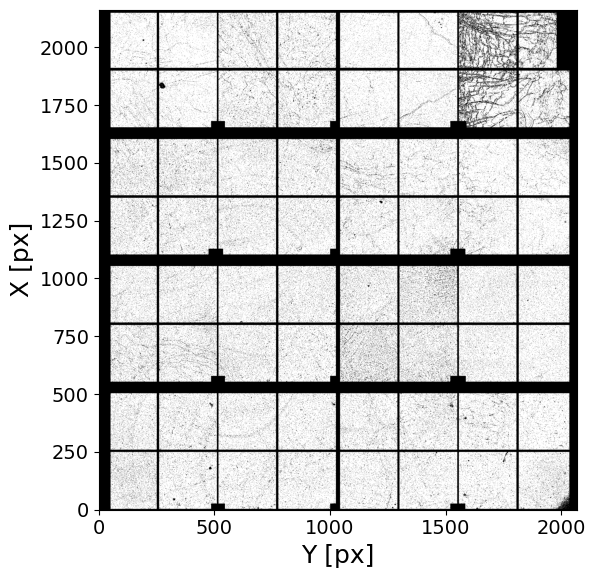

In [2]:
e4m_mask = np.load(MASKS_folder+'e4m_mask'+'.npy')
e4m_htmask = np.load(MASKS_folder+'e4m_htmask_Mo_fluorescence'+'.npy')

plt.figure(figsize=(6, 6))
plt.imshow((e4m_mask*e4m_htmask).reshape(Nx,Ny), cmap='gray', origin='lower')
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout(); plt.show()

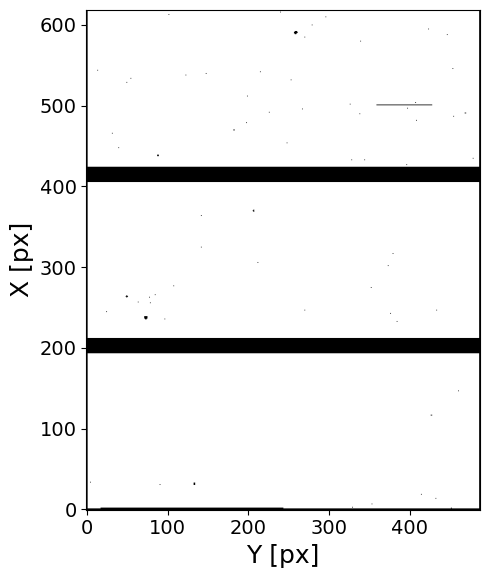

In [3]:
pilatus_mask = np.load(MASKS_folder+'pilatus300k_mask_20240201'+'.npy').astype(bool)

plt.figure(figsize=(6, 6))
plt.imshow(~pilatus_mask, cmap='gray', origin='lower')
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout(); plt.show()

## Q mask

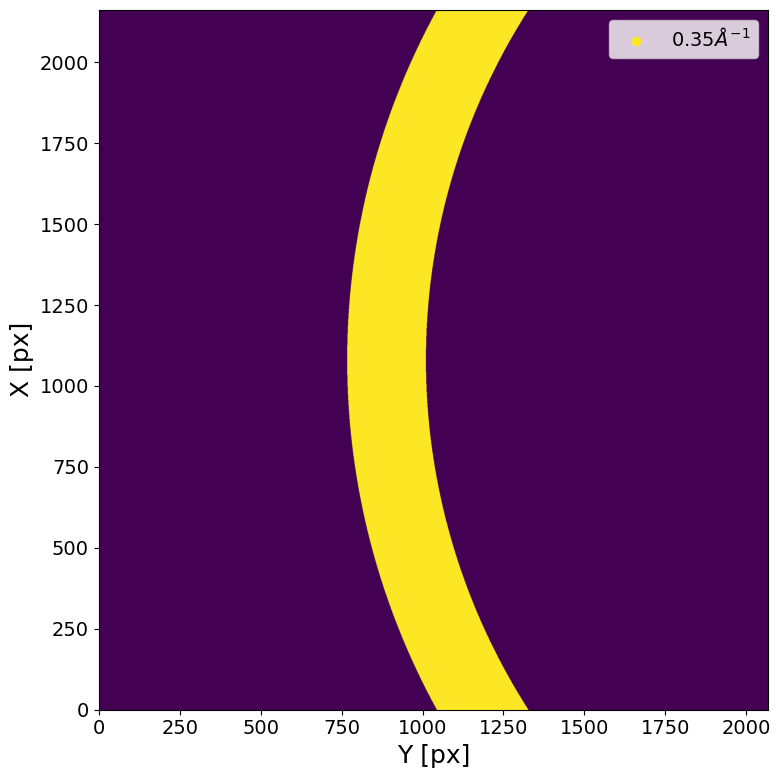

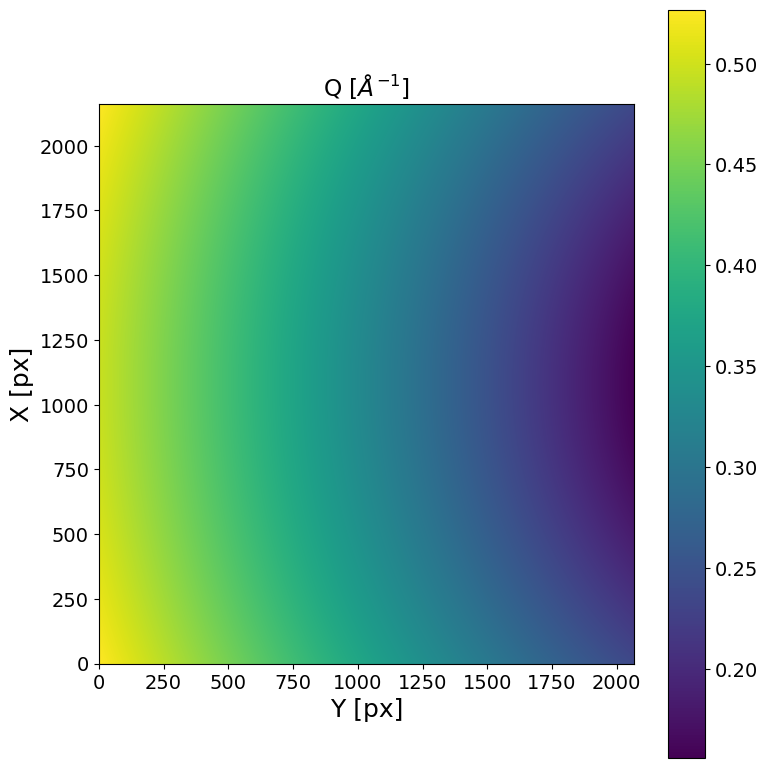

array([False, False, False, ..., False, False, False], shape=(4471016,))

In [4]:
###########
Q = 0.35
dq = 0.02
###########
Q=float(Q)


XPCS.gen_Qmask(21.669991317784486, 1.7, Q, dq, Qmap_plot=True)

## XPCS scan: delcoup=1.7, T=4h (Ta2O5_2.5um_asdep, 2, 1)  
difficile vedere qualcosa grande fondo di fluorescenza (soglia eiger a 4 keV)

#############################
command = mtimescan 0.001 2 86000367
Ei = 21.669991317784486
itime = 0.0011
T =  4.374549666666667 h
theta = 1.6999999999999993
Qc = 0.33
#############################



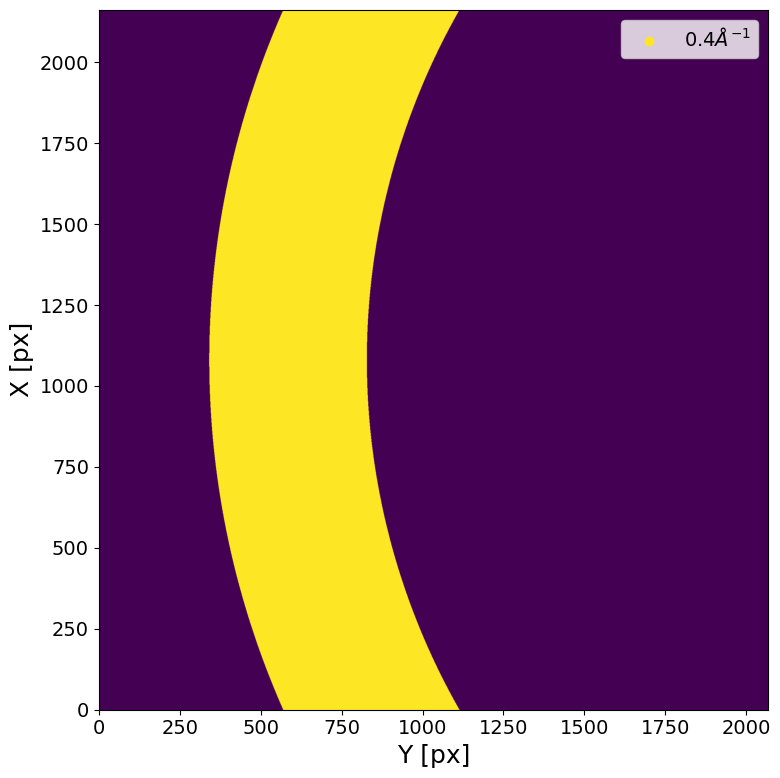

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00050.h5 (51/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00051.h5 (52/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00052.h5 (53/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00053.h5 (54/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00054.h5 (55/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00055.h5 (56/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00056.h5 (57/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00057.h5 (58/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00058.h5 (59/201 loops)
	 -> loading file eiger4m_v2

In [5]:
#######################################
sample_name = 'Ta2O5_2.5um_asdep'
Ndataset =2
Nscan = 1
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = None, int(1e6)
Qmask = XPCS.gen_Qmask(Ei, theta, Q, dq, Qmap_plot=False)
Kossel_mask = np.load(MASKS_folder+'Kossel_mask_Ta2O5_2.5um_asdep_0002_0001.npy')
load_mask = e4m_mask*e4m_htmask*Qmask*Kossel_mask
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

### Flux check

################################################################################
Maximum count in the whole run -> 5.0
# of pixels above Ith_high treshold ->  4351703 pixels (of 4471016 => 97.33 %)
# of pixels below Ith_low treshold ->  4263 pixels (of 4471016 => 0.1 %)
################################################################################



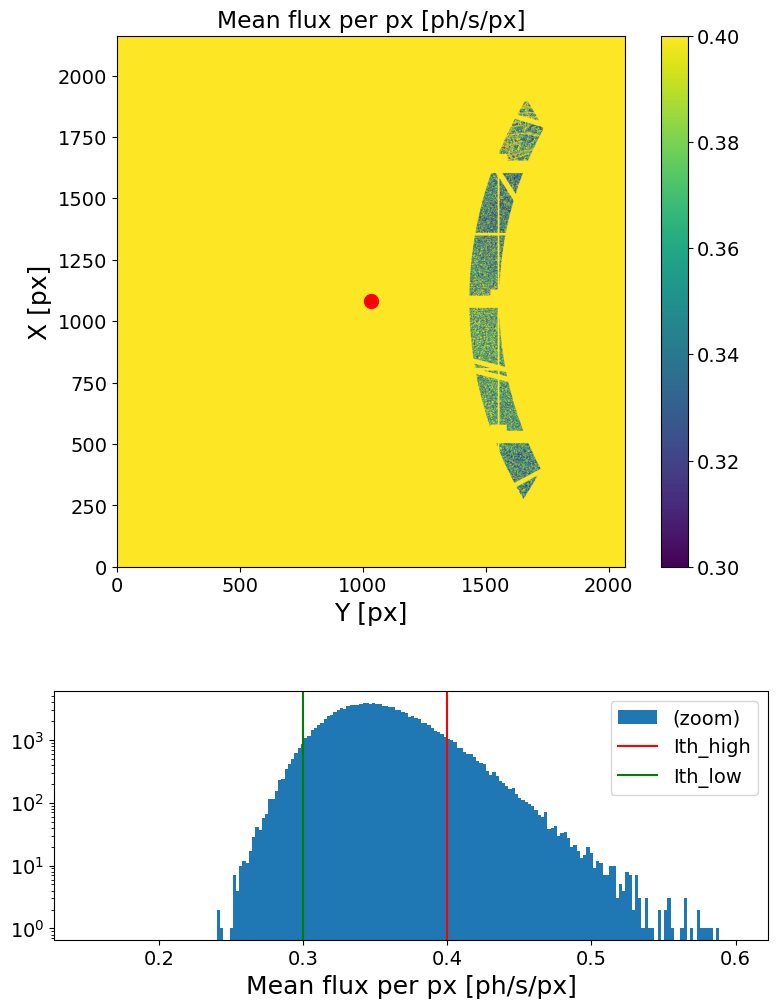

In [57]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_low=0.3, Ith_high=0.4, Nfi=None, Nff=int(1e7), load_mask=load_mask, mask=None)

### Intensity analysis

In [58]:
####################
Lbin = 100
Nstep = 1000
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)
np.savez(It_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_It=t_It, It=It)

UsageError: Line magic function `%plt.xscale('log')` not found.


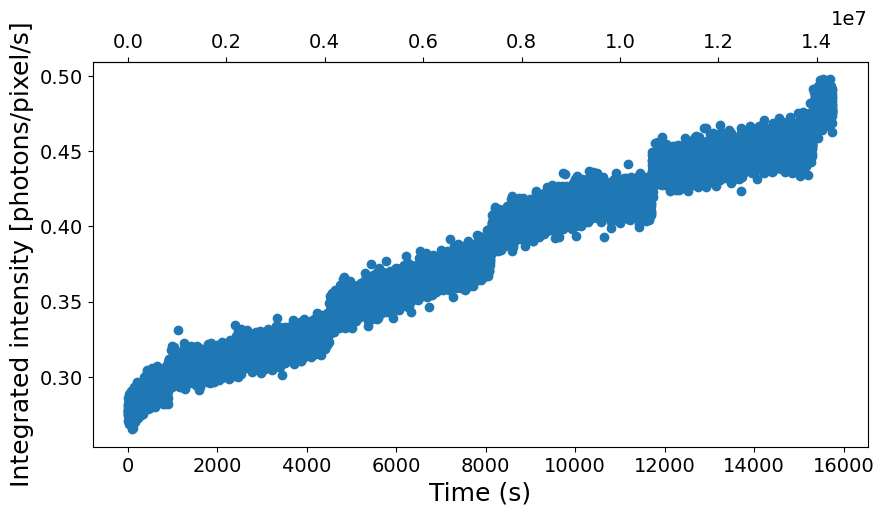

In [61]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
%plt.xscale('log')
plt.show()

### Linear correlation 4 tests

In [ ]:
###################
Nfi = None
Nff = None
Lbin = 1000
bin2dense = True
mask = None
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

Loading frames ...
Done! (elapsed time = 0.0 s)
Binning frames (Lbin = 1000, using MKL library) ...


Done! (elapsed time = 7.68 s)
	 | 14316 frames X 202076 pixels
	 | memory usage (np.array @ float32) = 10.777 GB
Computing G2t (using MKL library)...


Exception ignored in: <function ResourceTracker.__del__ at 0x7f13e68dfba0>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fd9431abba0>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", li

In [ ]:
############################
t1, t2 = 0, 15000
vmin, vmax = 1.0, 1.03
############################
#XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=t1, t2=t2, sigma_filter=None)

In [ ]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t_g2, g2, dg2, t_mt, g2_mt, dg2_mt = {}, {}, {}, {}, {}, {}
for n in range(Nbunch):
    if Nfi is None: Nfi = 0
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)

    if Nbunch!=1: t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]))
    else:         t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
    t_mt[t_bunch], g2_mt[t_bunch], dg2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch],dg2[t_bunch])   


Computing g2 (using cython code)...
Done! (elapsed time = 0.11 s)



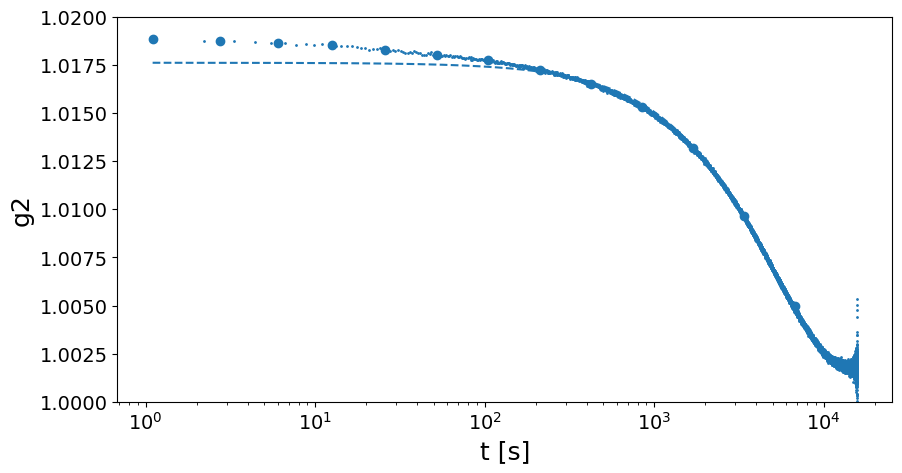

Parameters([('tau', <Parameter 'tau', value=np.float64(4816.877530198486) +/- 3.29, bounds=[0:1000000.0]>), ('beta', <Parameter 'beta', value=np.float64(1.1393908619980408) +/- 0.0012, bounds=[0:2]>), ('c', <Parameter 'c', value=np.float64(0.016628190482821298) +/- 1.08e-05, bounds=[0:1]>), ('y0', <Parameter 'y0', value=np.float64(1.0009866147103075) +/- 6.61e-06, bounds=[0:2]>)])

In [ ]:
##################
t1_fit = 0
t2_fit = 1e100
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
#params.add('y0', value=1.001, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t_g2[k], g2[k], s=1,  c='C'+str(i), label = str(k)+'s')
    plt.errorbar(t_mt[k], g2_mt[k], yerr = dg2_mt[k],fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]


    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')


plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.02)
#plt.legend()
plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.tight_layout(); plt.show()

### Linear by dose

In [ ]:
t_ff = e4m_data.shape[0]*itime
print('#############################')
print('Nff =    =',e4m_data.shape[0], ' =>  t_ff =', t_ff)
print('#############################\n')

#############################
Nff =    = 14316864  =>  t_ff = 15748.5504
#############################



In [ ]:
########################################
#N_segments = 5
t_segments = [0, 500, 2000, 5000, 10000, 15748] #np.linspace(0, int(t_ff), N_segments)
t_skip = [] # skip if Nfi is in t_skip
########################################

Nf_segments = [int (t/itime) for t in t_segments]
Nf_skip = [int(t/itime) for t in t_skip]

In [ ]:
from contextlib import redirect_stdout
import io

###################
Lbin = 100
bin2dense = False
mask = None
###################

t_g2, g2, dg2= {}, {}, {}
for i in tqdm(range(len(Nf_segments)-1)):
    with redirect_stdout(io.StringIO()):
        Nfi = Nf_segments[i]
        Nff = Nf_segments[i+1]
        if not Nfi in Nf_skip:
            G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)
            t_bunch = Nfi*itime + (Nff-Nfi)/2*itime
            t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_g2=t_g2, g2=g2, dg2=dg2)

100%|██████████| 5/5 [03:25<00:00, 41.07s/it]


/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects w

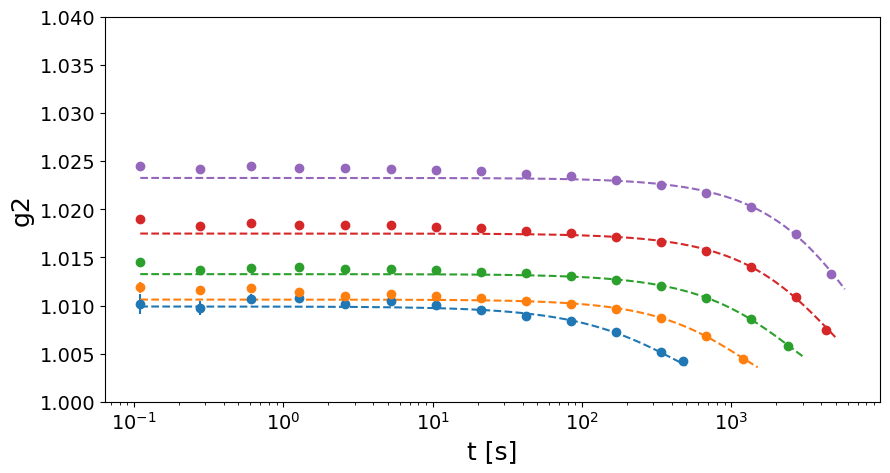

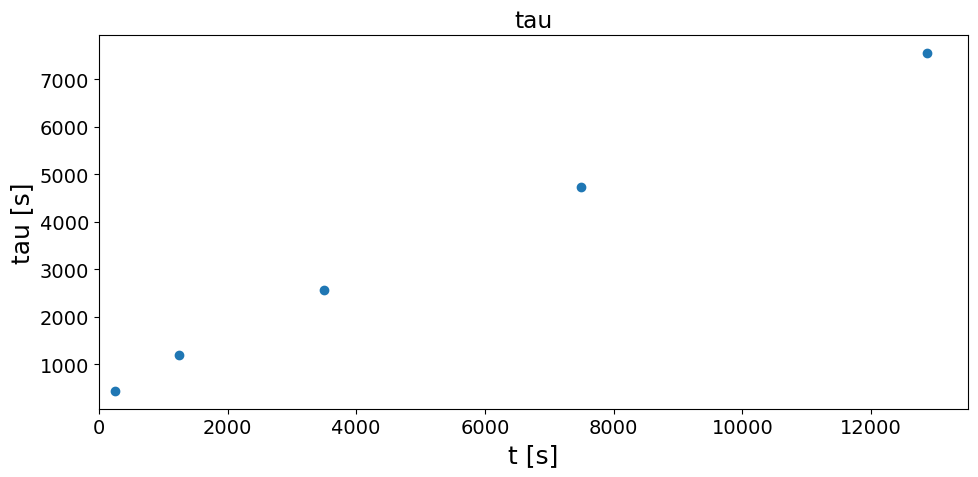

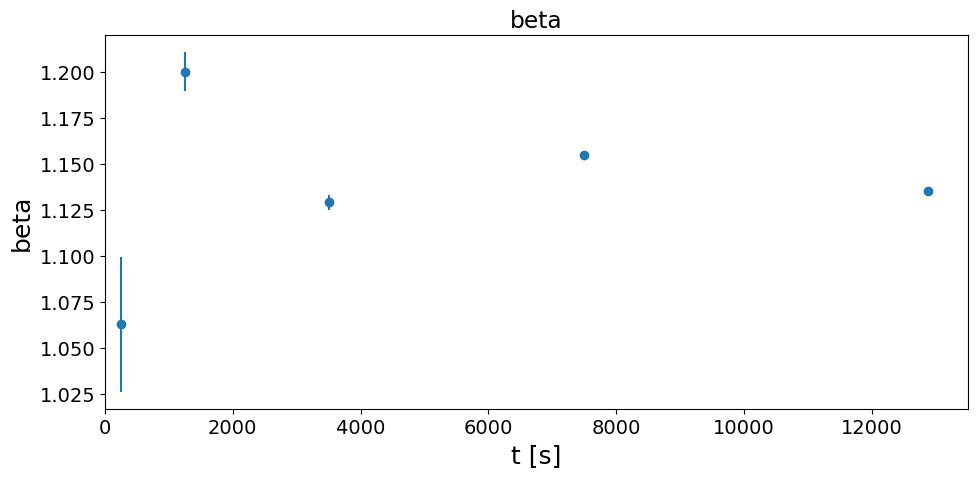

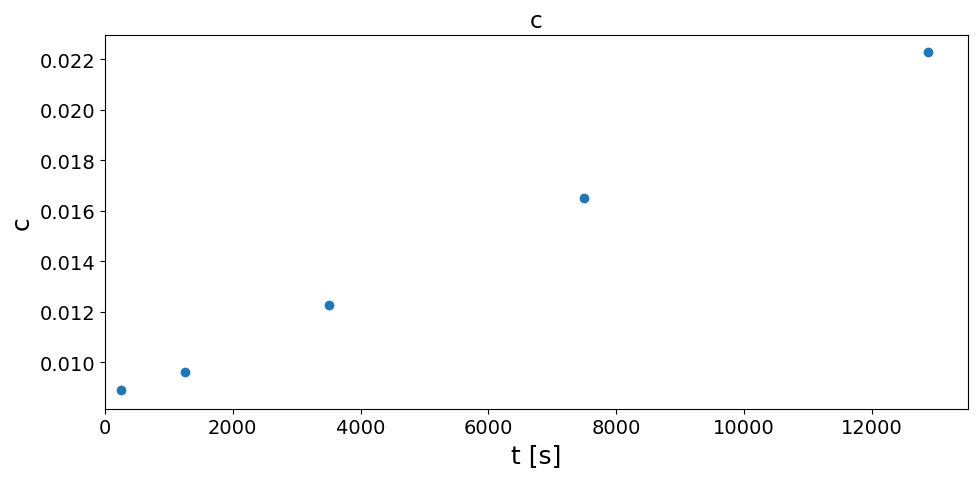

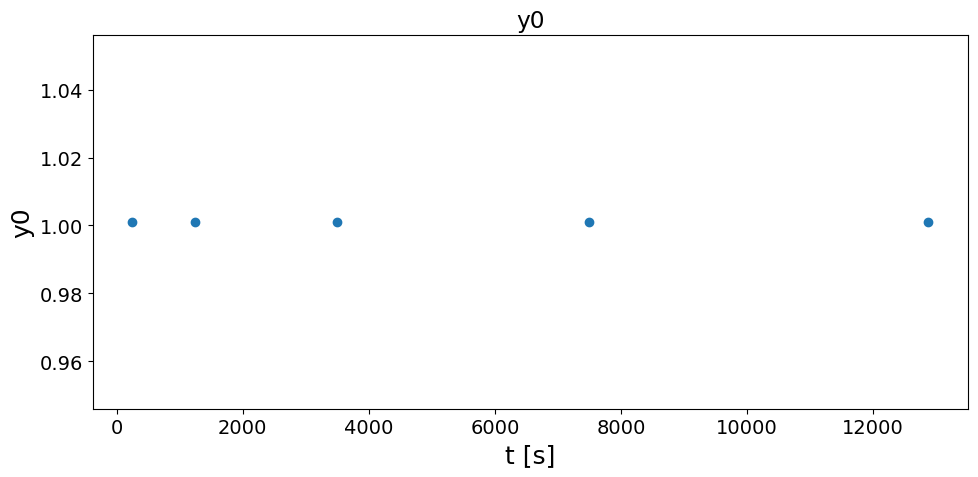

In [ ]:
##################
t1_fit = 0
t2_fit = 1e10
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=50, min=0, max=1e6)
params.add('beta', value=0.8, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
#params.add('y0', value=1, min=0, max=2)
params.add('y0', value=1.001, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    #plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

g2_fit.to_csv(g2fit_folder+'g2fit_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.04)
#plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title('tau')
plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('tau [s]')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('beta')
plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('beta')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('c')
plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('c')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('y0')
plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('y0')
plt.tight_layout(); plt.show()

## XPCS scan: delcoup=1.7, T=4h (Ta2O5_2.5um_asdep, 4, 5)  

Tantala as deposited

#############################
command = mtimescan 0.001 1 16000128
Ei = 21.669991317784486
itime = 0.0011
T =  4.888928 h
theta = 1.6999999999999993
Qc = 0.33
#############################



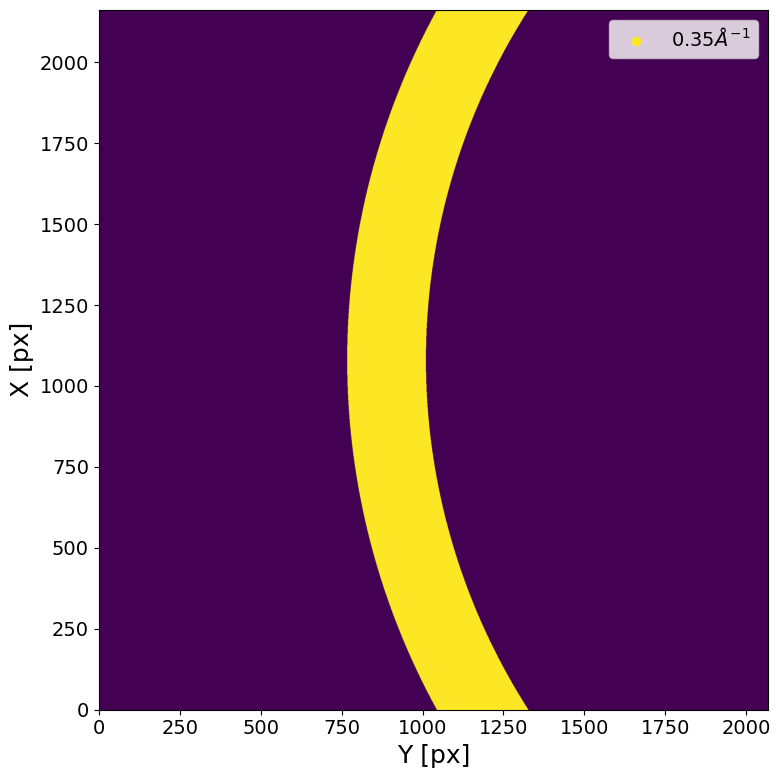

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/3201 loops)


Exception ignored in: Exception ignored in: <function ResourceTracker.__del__ at 0x7504c919bce0>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: Exception ignored in: <function ResourceTracker.__del__ at 0x79d58e487ce0>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
Exception ignored in: <function ResourceTracker.__del__ at 0x76de17d67ce0>Exception ign

: 

: 

In [28]:
#######################################
sample_name = 'Ta2O5_2.5um_asdep'
Ndataset =4
Nscan = 5
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = None, None
Qmask = XPCS.gen_Qmask(Ei, theta, Q, dq, Qmap_plot=False)
Kossel_mask = np.load(MASKS_folder+'Kossel_mask_Ta2O5_2.5um_asdep_0002_0001.npy')
load_mask = e4m_mask*e4m_htmask*Kossel_mask*Qmask
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

### Flux check

################################################################################
Maximum count in the whole run -> 5.0
# of pixels above Ith_high treshold ->  4053542 pixels (of 4471016 => 90.66 %)
# of pixels below Ith_low treshold ->  3030 pixels (of 4471016 => 0.07 %)
################################################################################



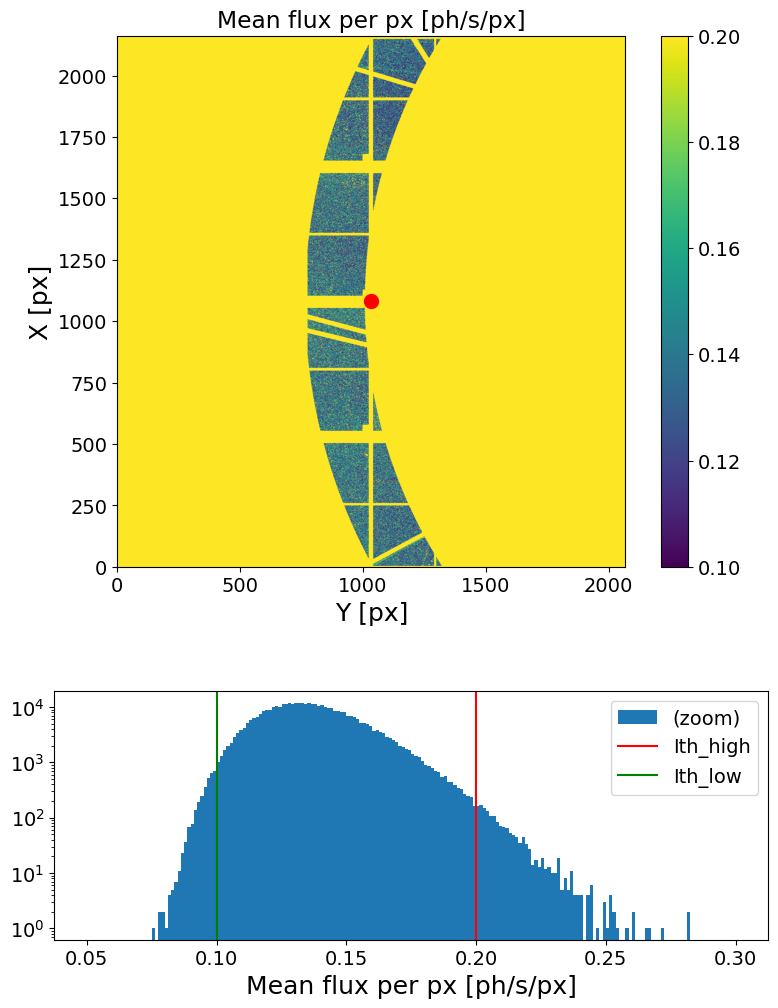

In [22]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_low=0.1, Ith_high=0.2, Nfi=None, Nff=int(1e7), load_mask=load_mask, mask=None)

### Intensity analysis

In [16]:
####################
Lbin = 100
Nstep = 1000
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)
np.savez(It_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_It=t_It, It=It)

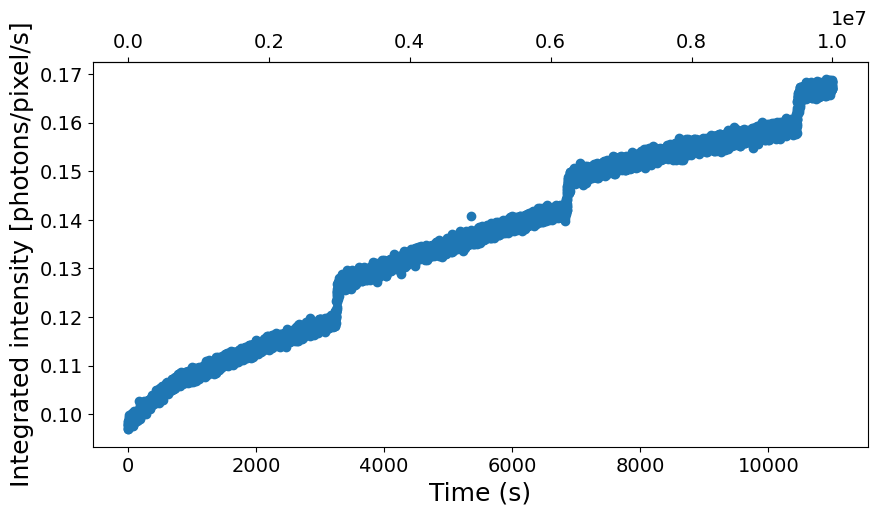

In [17]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
#plt.xscale('log')
plt.show()

### Linear correlation 4 tests

In [25]:
###################
Nfi = None
Nff = None
Lbin = 1000
bin2dense = True
mask = None
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

Loading frames ...
Done! (elapsed time = 0.0 s)
Binning frames (Lbin = 1000, using MKL library) ...
Done! (elapsed time = 2.1 s)
	 | 10000 frames X 419064 pixels
	 | memory usage (np.array @ float32) = 15.611 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 8.71 s)
	 | 10000 X 10000 squared matrix
	 | memory usage (np.array @ float32) = 0.373 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.73 s)



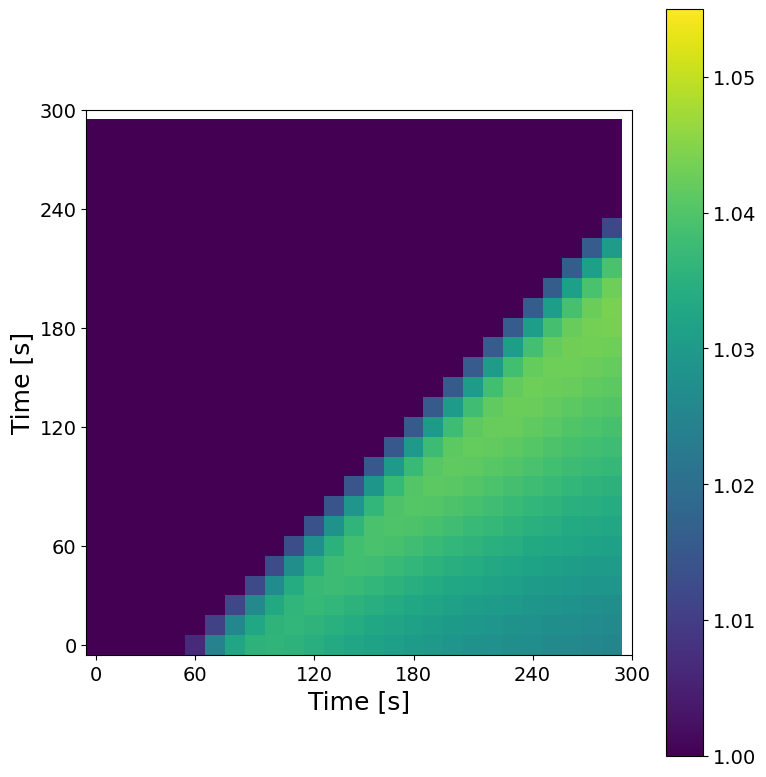

In [12]:
############################
t1, t2 = 0, 300
vmin, vmax = 1.0, 1.055
############################
XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=t1, t2=t2, sigma_filter=2)

In [26]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t_g2, g2, dg2, t_mt, g2_mt, dg2_mt = {}, {}, {}, {}, {}, {}
for n in range(Nbunch):
    if Nfi is None: Nfi = 0
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)

    if Nbunch!=1: t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]))
    else:         t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
    t_mt[t_bunch], g2_mt[t_bunch], dg2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch],dg2[t_bunch])   


Computing g2 (using cython code)...
Done! (elapsed time = 0.06 s)



/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


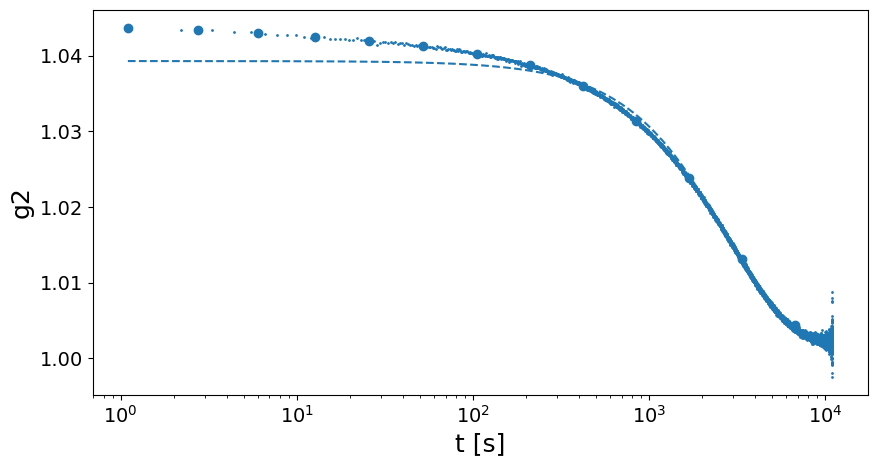

Parameters([('tau', <Parameter 'tau', value=np.float64(2757.9542510497836) +/- 2.7, bounds=[0:1000000.0]>), ('beta', <Parameter 'beta', value=1.3 (fixed), bounds=[-inf:inf]>), ('c', <Parameter 'c', value=np.float64(0.036802515809672566) +/- 1.71e-05, bounds=[0:1]>), ('y0', <Parameter 'y0', value=np.float64(1.0024774381092327) +/- 1.26e-05, bounds=[0:2]>)])

In [27]:
##################
t1_fit = 0
t2_fit = 1e100
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('beta', value=1.3, vary=False)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
#params.add('y0', value=1.00096757, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t_g2[k], g2[k], s=1,  c='C'+str(i), label = str(k)+'s')
    plt.errorbar(t_mt[k], g2_mt[k], yerr = dg2_mt[k],fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]


    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
#plt.ylim(1, 1.06)
#plt.legend()
plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    display(g2_fit)
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.tight_layout(); plt.show()

In [26]:
t_mesh = np.array([20, 40, 60, 200, 400])*1.1
t_base = np.array((2e3, 2e3, 2e3, 3e3, .6e4))*1.1

npt = 50


T = np.sum(t_mesh*npt)
print(T/3600)

T1 = np.sum(t_base)
print(T1/3600)
T = T+T1
print(T/3600-16)   

11.0
4.583333333333333
-0.4166666666666661


### Linear by dose

In [68]:
t_ff = e4m_data.shape[0]*itime
print('#############################')
print('Nff =    =',e4m_data.shape[0], ' =>  t_ff =', t_ff)
print('#############################\n')

#############################
Nff =    = 16000128  =>  t_ff = 17600.1408
#############################



In [69]:
########################################
#N_segments = 5
t_segments = [0, 50, 200, 500, 1000]#[0, 1000, 5000, 17600] #np.linspace(0, int(t_ff), N_segments)
t_skip = [] # skip if Nfi is in t_skip
########################################

Nf_segments = [int (t/itime) for t in t_segments]
Nf_skip = [int(t/itime) for t in t_skip]

In [70]:
###################
Lbin = 1000
bin2dense = True
mask = None
###################

t_g2, g2, dg2= {}, {}, {}
for i in tqdm(range(len(Nf_segments)-1)):
    with redirect_stdout(io.StringIO()):
        Nfi = Nf_segments[i]
        Nff = Nf_segments[i+1]
        if not Nfi in Nf_skip:
            G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)
            t_bunch = Nfi*itime + (Nff-Nfi)/2*itime
            t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_g2=t_g2, g2=g2, dg2=dg2)

100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects w

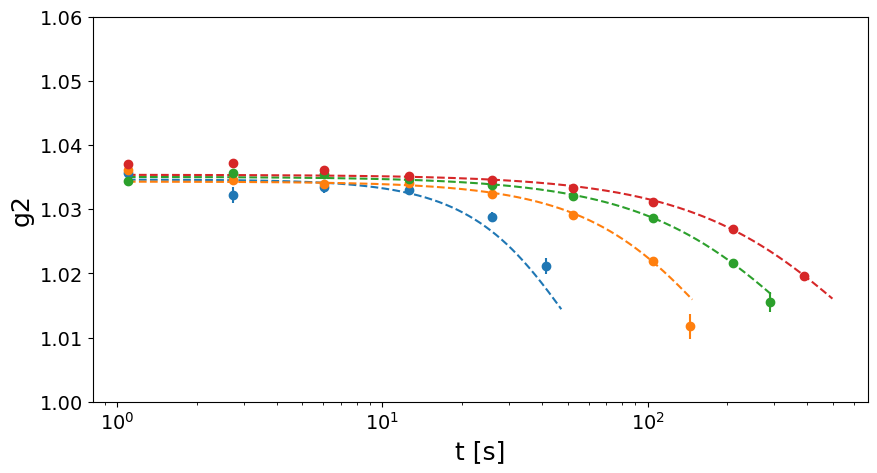

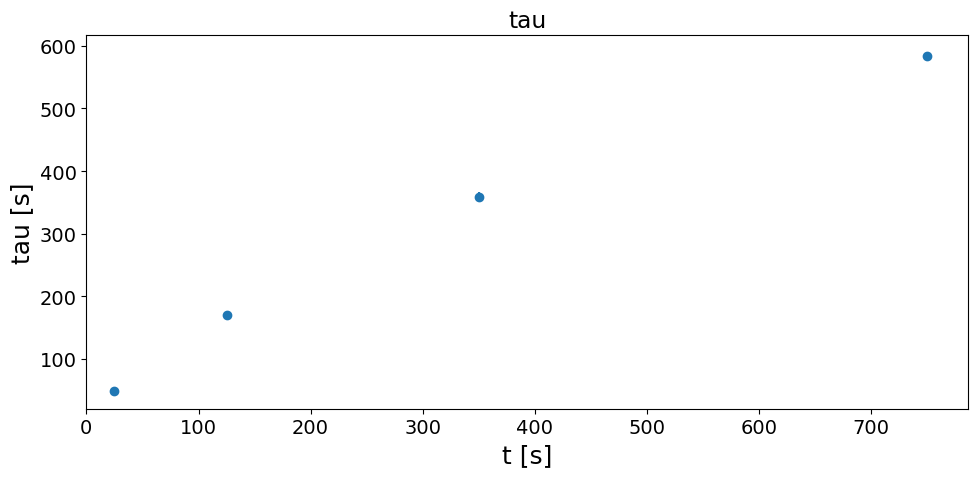

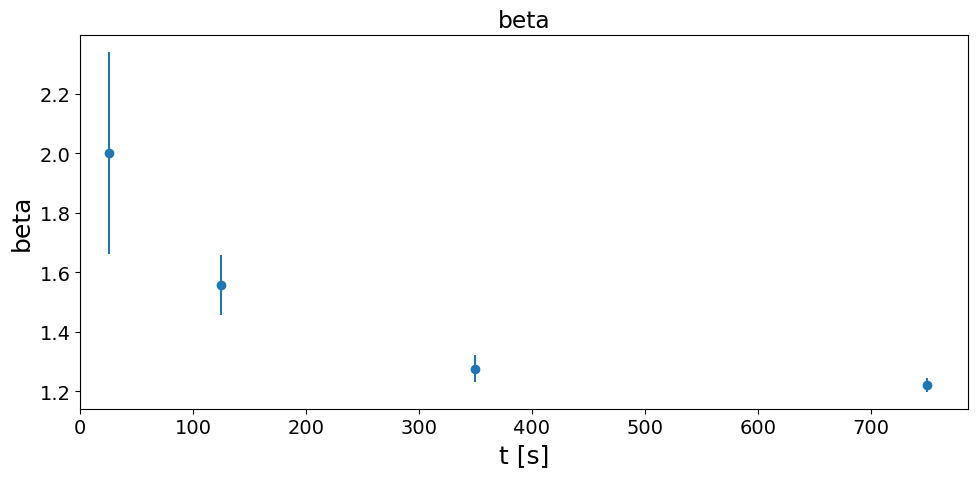

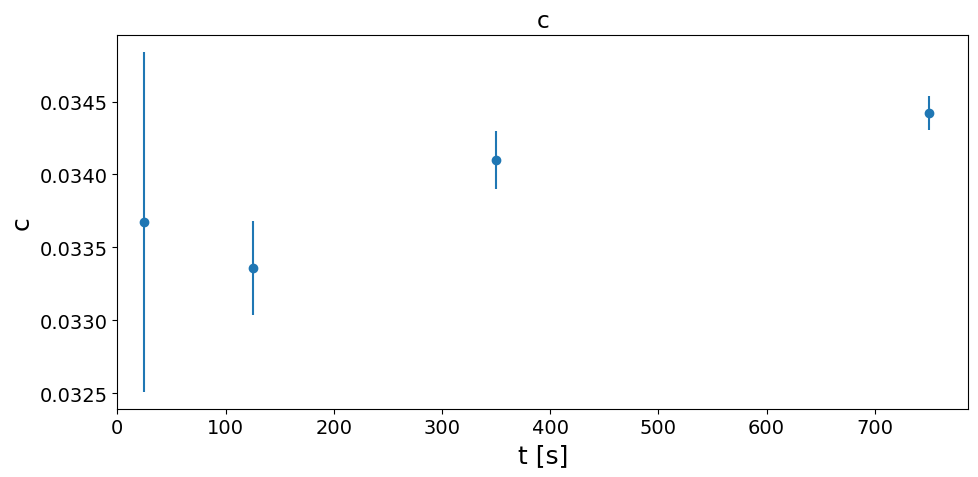

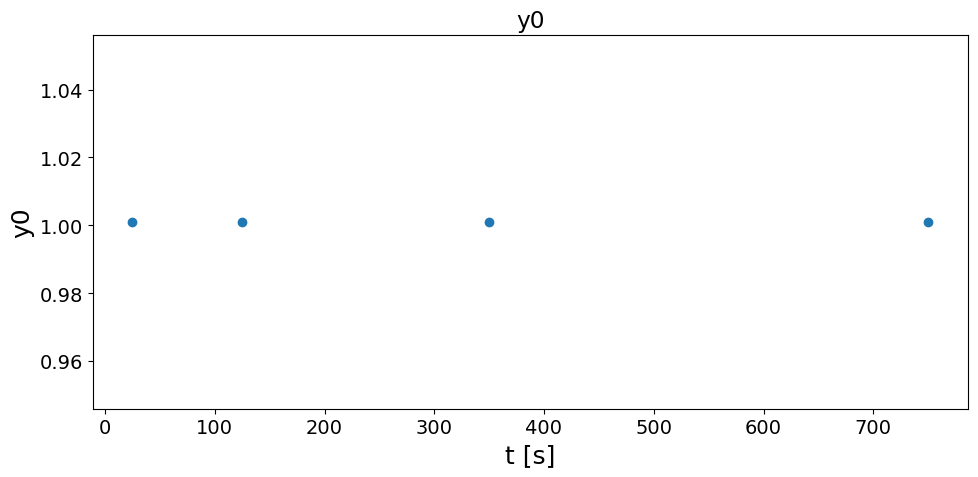

In [71]:
##################
t1_fit = 0
t2_fit = 1e10
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=50, min=0, max=1e6)
params.add('beta', value=0.8, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
#params.add('y0', value=1, min=0, max=2)
params.add('y0', value=1.00096757, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    #plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

g2_fit.to_csv(g2fit_folder+'g2fit_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.06)
#plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title('tau')
plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('tau [s]')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('beta')
plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('beta')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('c')
plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('c')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('y0')
plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('y0')
plt.tight_layout(); plt.show()

## XPCS scan: delcoup=1.7, T=4h (Ta2O5_2.5um_asdep, 4, 9)  

Tantala as deposited, went back in the spot dameged by 16 hours irradiation (Ta2O5 2, 4) and measure again to add points in high dose region

#############################
command = mtimescan 0.001 2 86000367
Ei = 21.669991317784486
itime = 0.0011
T =  3.3802202500000003 h
theta = 1.6999999999999993
Qc = 0.33
#############################



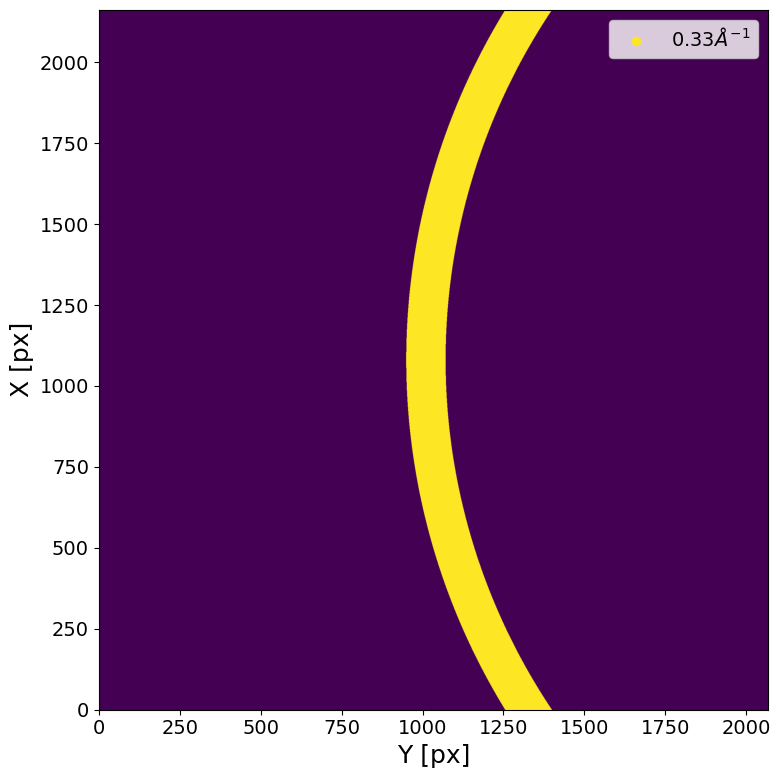

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00014.h5 (15/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00013.h5 (14/201 loops)
	 -> loading file eiger4m_v2_spa

In [21]:
#######################################
sample_name = 'Ta2O5_2.5um_asdep'
Ndataset =4
Nscan = 9
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = None, int(1e6)#len(scan['fast_timer_period'])-5001
Q=0.33
Qmask = XPCS.gen_Qmask(Ei, theta, Q, dq, Qmap_plot=False)
Kossel_mask = np.load(MASKS_folder+'Kossel_mask_Ta2O5_2.5um_asdep_0002_0001.npy')
load_mask = e4m_mask*e4m_htmask#*Qmask*Kossel_mask
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

### Flux check

################################################################################
Maximum count in the whole run -> 4.0
# of pixels above Ith_high treshold ->  1433799 pixels (of 4471016 => 32.07 %)
# of pixels below Ith_low treshold ->  25157 pixels (of 4471016 => 0.56 %)
################################################################################



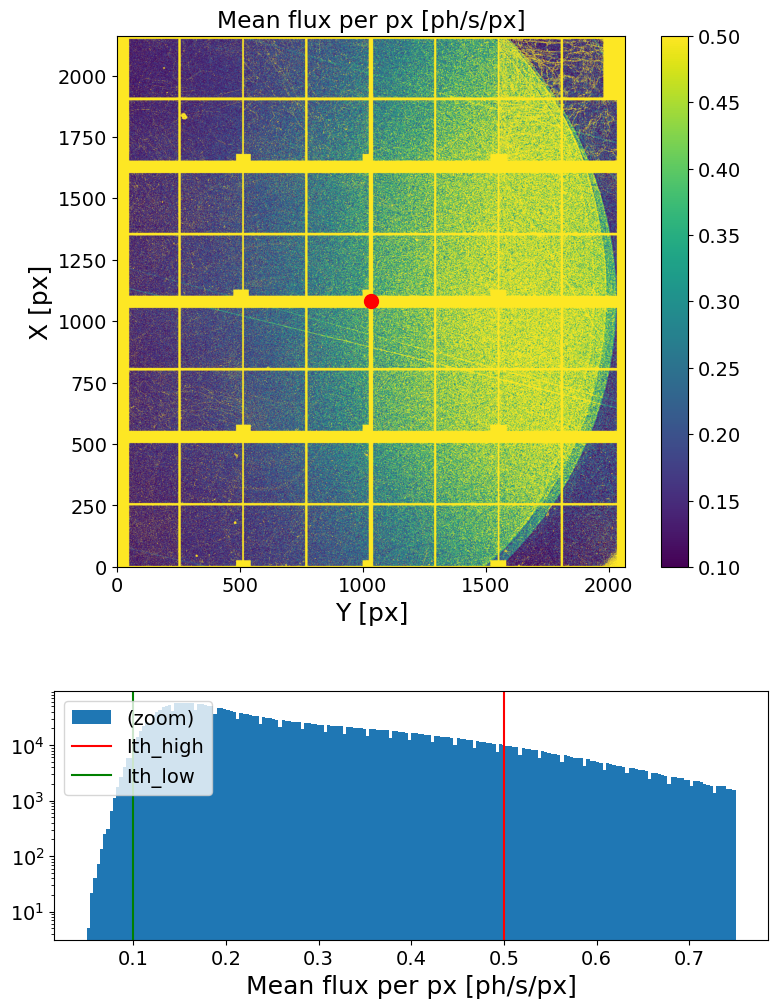

In [22]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_low=0.1, Ith_high=0.5, Nfi=None, Nff=int(1e7), load_mask=load_mask, mask=None)

### Intensity analysis

In [10]:
####################
Lbin = 1000
Nstep = 1000
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)
np.savez(It_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_It=t_It, It=It)

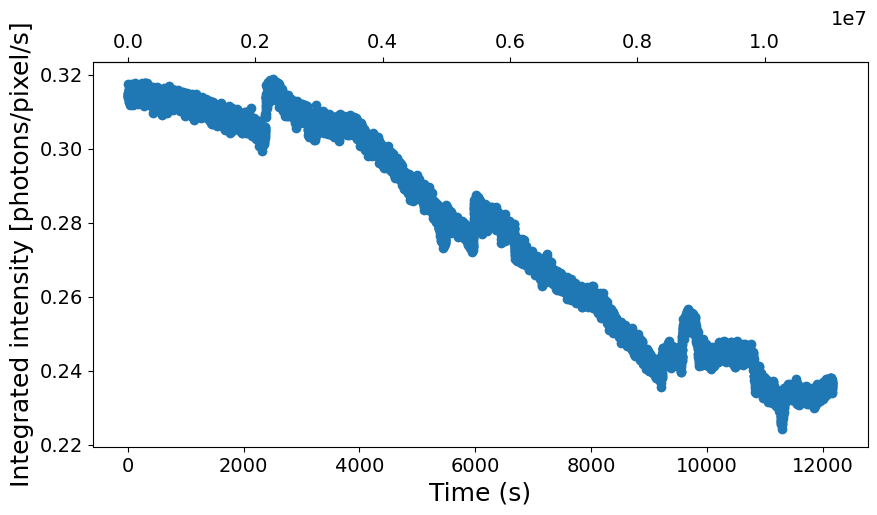

In [11]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
#plt.xscale('log')
plt.show()

### Linear correlation 4 tests

In [22]:
###################
Nfi = None
Nff = None
Lbin = 1000
bin2dense = True
mask = None
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

Loading frames ...
Done! (elapsed time = 0.0 s)
Binning frames (Lbin = 1000, using MKL library) ...
Done! (elapsed time = 3.88 s)
	 | 11062 frames X 202076 pixels
	 | memory usage (np.array @ float32) = 8.327 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 14.5 s)
	 | 11062 X 11062 squared matrix
	 | memory usage (np.array @ float32) = 0.456 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.79 s)



In [23]:
############################
t1, t2 = 0, 2000
vmin, vmax = 1.0, 1.07
############################
#XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=t1, t2=t2, sigma_filter=None)

In [24]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t_g2, g2, dg2, t_mt, g2_mt, dg2_mt = {}, {}, {}, {}, {}, {}
for n in range(Nbunch):
    if Nfi is None: Nfi = 0
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1) + 56545.8718  ### Add the time of the previous irradiation

    if Nbunch!=1: t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]))
    else:         t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
    t_mt[t_bunch], g2_mt[t_bunch], dg2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch],dg2[t_bunch])   
np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_g2=t_g2, g2=g2, dg2=dg2)

Computing g2 (using cython code)...
Done! (elapsed time = 0.07 s)



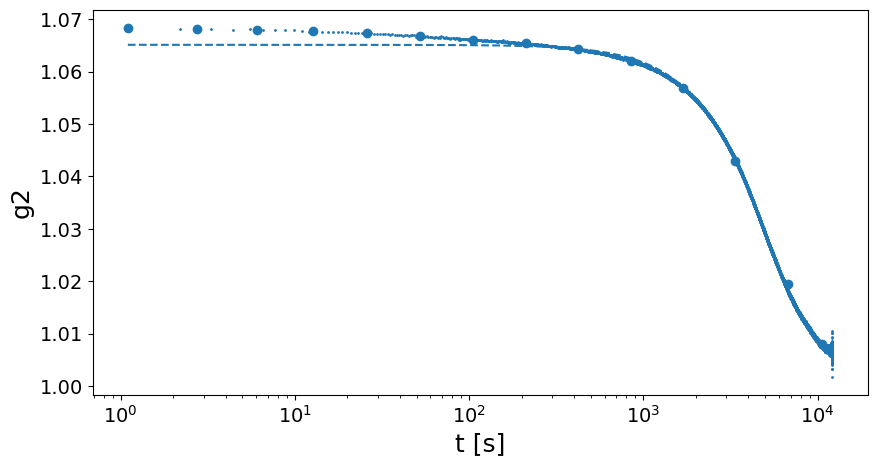

Parameters([('tau', <Parameter 'tau', value=np.float64(5206.075281883965) +/- 2.32, bounds=[0:1000000.0]>), ('beta', <Parameter 'beta', value=np.float64(1.7164102921680622) +/- 0.00128, bounds=[0:2]>), ('c', <Parameter 'c', value=np.float64(0.05913710739411653) +/- 2.78e-05, bounds=[0:1]>), ('y0', <Parameter 'y0', value=np.float64(1.0059634663872794) +/- 2.18e-05, bounds=[0:2]>)])

In [25]:
##################
t1_fit = 0
t2_fit = 1e100
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.0725, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
#params.add('y0', value=1.003, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t_g2[k], g2[k], s=1,  c='C'+str(i), label = str(k)+'s')
    plt.errorbar(t_mt[k], g2_mt[k], yerr = dg2_mt[k],fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]


    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

g2_fit.to_csv(g2fit_folder+'g2fit_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
#plt.ylim(1, 1.06)
#plt.legend()
plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.tight_layout(); plt.show()

### Linear by dose

In [30]:
t_ff = e4m_data.shape[0]*itime
print('#############################')
print('Nff =    =',e4m_data.shape[0], ' =>  t_ff =', t_ff)
print('#############################\n')

#############################
Nff =    = 11062673  =>  t_ff = 12168.9403
#############################



In [38]:
########################################
#N_segments = 5
t_segments = [0, 5000, t_ff] #np.linspace(0, int(t_ff), N_segments)
t_skip = [] # skip if Nfi is in t_skip
########################################

Nf_segments = [int (t/itime) for t in t_segments]
Nf_skip = [int(t/itime) for t in t_skip]

In [39]:
###################
Lbin = 1000
bin2dense = True
mask = None
###################

t_g2, g2, dg2= {}, {}, {}
for i in tqdm(range(len(Nf_segments)-1)):
    with redirect_stdout(io.StringIO()):
        Nfi = Nf_segments[i]
        Nff = Nf_segments[i+1]
        if not Nfi in Nf_skip:
            G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)
            t_bunch = Nfi*itime + (Nff-Nfi)/2*itime + 56545.8718  ### Add the time of the previous irradiation
            t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
#np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_g2=t_g2, g2=g2, dg2=dg2)

100%|██████████| 2/2 [00:18<00:00,  9.42s/it]


/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


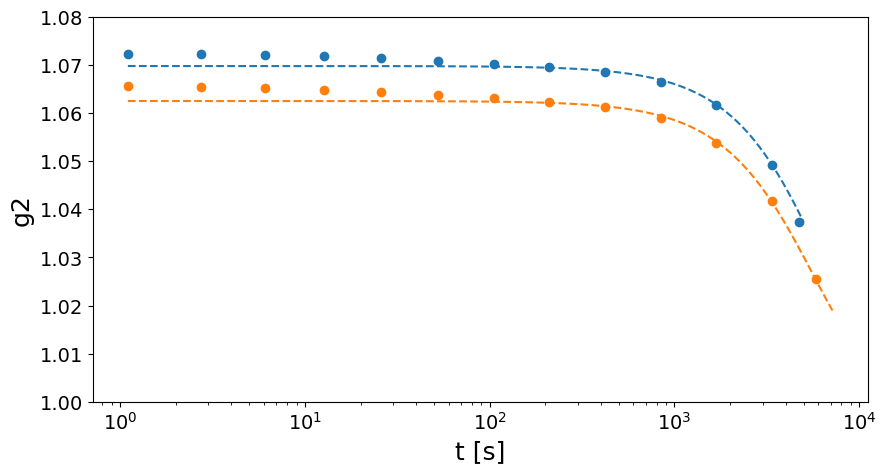

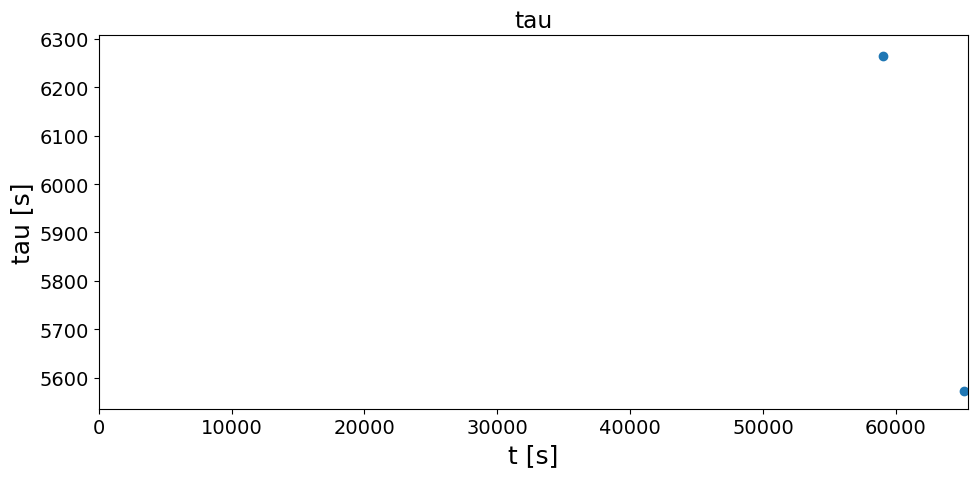

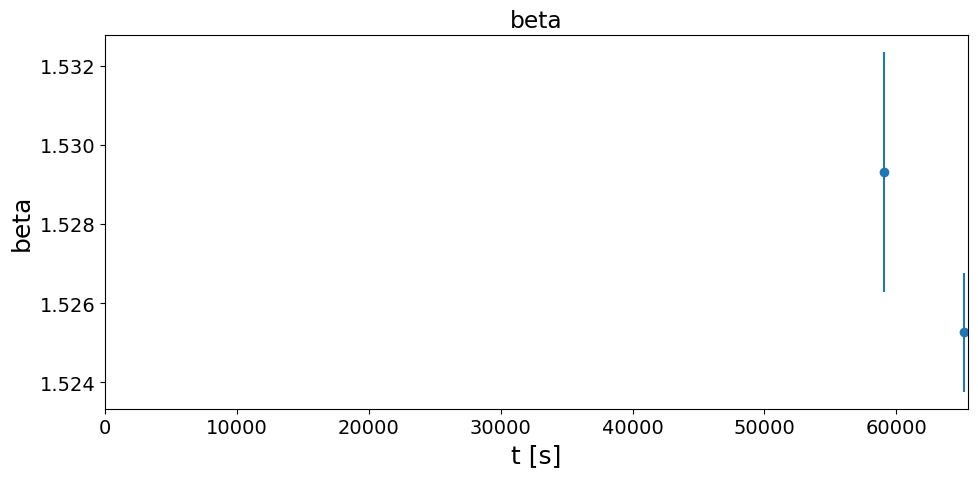

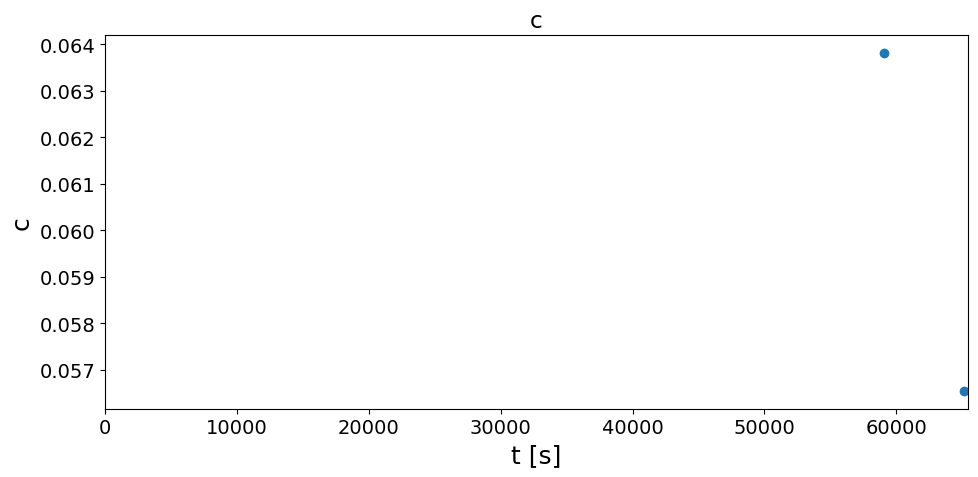

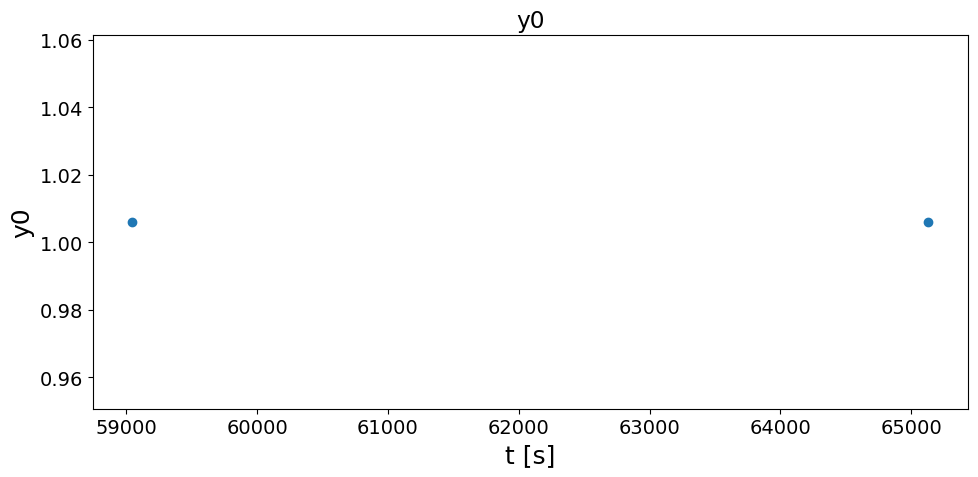

In [40]:
##################
t1_fit = 0
t2_fit = 1e10
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=50, min=0, max=1e6)
params.add('beta', value=0.8, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
#params.add('y0', value=1, min=0, max=2)
params.add('y0', value=1.00596347, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    #plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

#g2_fit.to_csv(g2fit_folder+'g2fit_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.08)
#plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title('tau')
plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('tau [s]')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('beta')
plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('beta')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('c')
plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('c')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('y0')
plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('y0')
plt.tight_layout(); plt.show()

### Linear by dose

In [ ]:
t_ff = e4m_data.shape[0]*itime
print('#############################')
print('Nff =    =',e4m_data.shape[0], ' =>  t_ff =', t_ff)
print('#############################\n')

#############################
Nff =    = 11062673  =>  t_ff = 12168.9403
#############################



Exception ignored in: <function ResourceTracker.__del__ at 0x784f8959fc40>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x70d9b7b8fc40>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", li

In [ ]:
########################################
#N_segments = 5
t_segments = [0, 1000, 5000, 17600] #np.linspace(0, int(t_ff), N_segments)
t_skip = [] # skip if Nfi is in t_skip
########################################

Nf_segments = [int (t/itime) for t in t_segments]
Nf_skip = [int(t/itime) for t in t_skip]

In [ ]:
###################
Lbin = 1000
bin2dense = True
mask = None
###################

t_g2, g2, dg2= {}, {}, {}
for i in tqdm(range(len(Nf_segments)-1)):
    with redirect_stdout(io.StringIO()):
        Nfi = Nf_segments[i]
        Nff = Nf_segments[i+1]
        if not Nfi in Nf_skip:
            G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)
            t_bunch = Nfi*itime + (Nff-Nfi)/2*itime
            t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_g2=t_g2, g2=g2, dg2=dg2)

100%|██████████| 3/3 [00:33<00:00, 11.06s/it]


/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


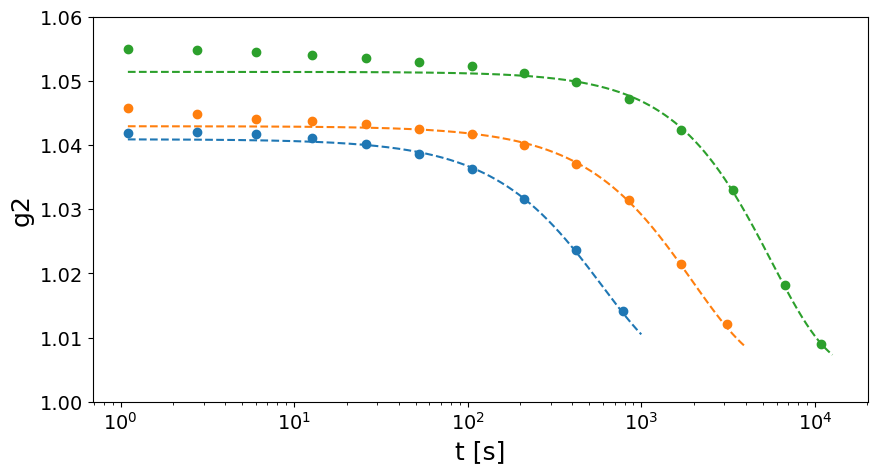

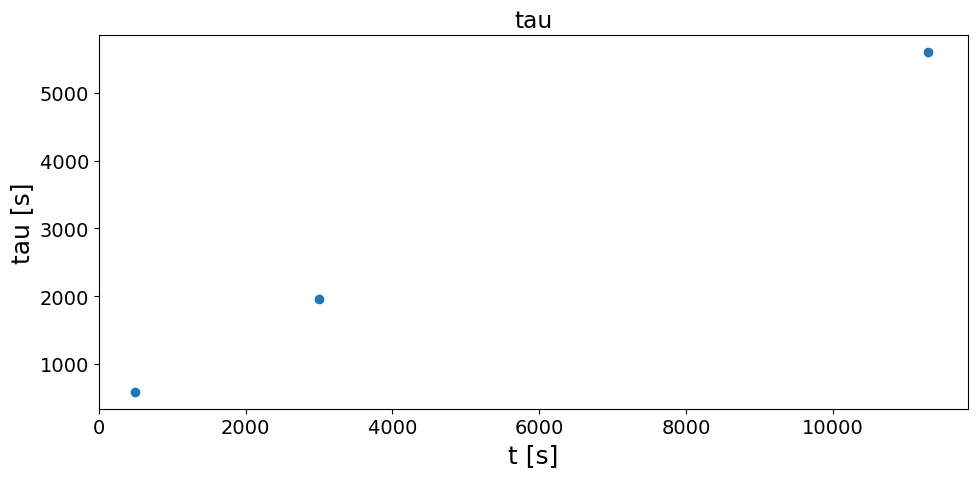

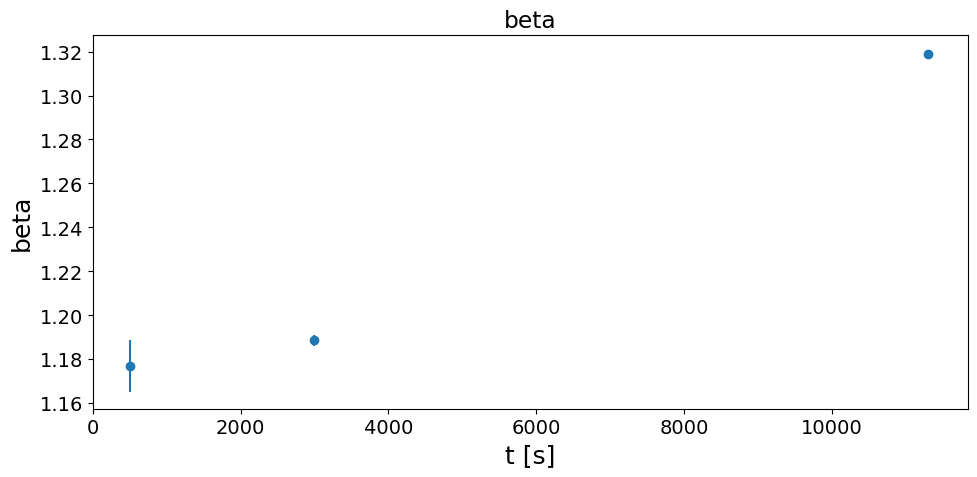

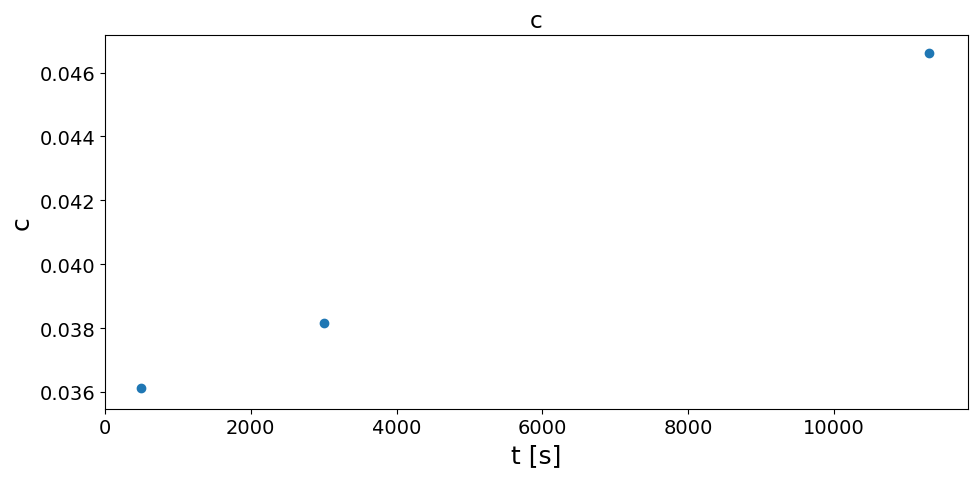

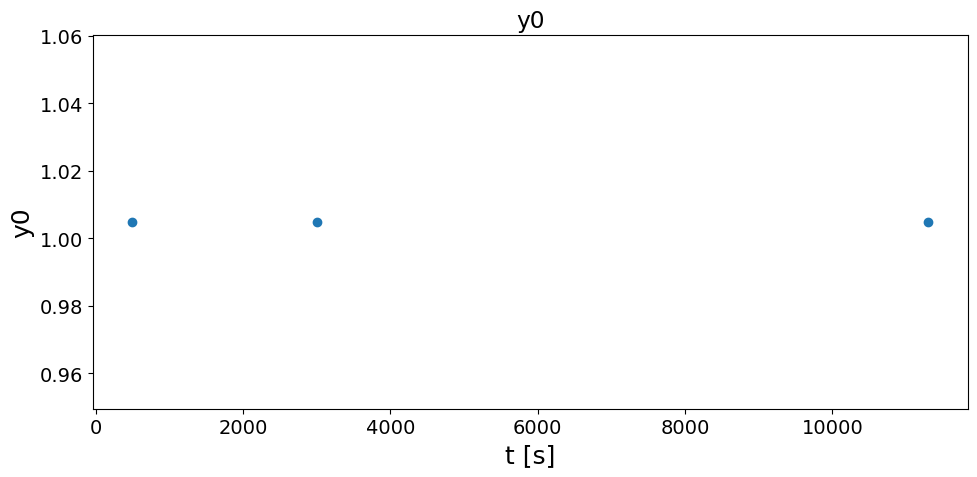

In [ ]:
##################
t1_fit = 0
t2_fit = 1e10
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=50, min=0, max=1e6)
params.add('beta', value=0.8, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
#params.add('y0', value=1, min=0, max=2)
params.add('y0', value=1.0048, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    #plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

g2_fit.to_csv(g2fit_folder+'g2fit_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.06)
#plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title('tau')
plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('tau [s]')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('beta')
plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('beta')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('c')
plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('c')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('y0')
plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('y0')
plt.tight_layout(); plt.show()

## XPCS scan: delcoup=1.7, T=12h (Ta2O5_2.5um_B, 1, 2)  
Tantala annealed

#############################
command = mtimescan 0.001 2 86000367
Ei = 21.669991317784486
itime = 0.0011
T =  9.725150722222223 h
theta = 1.6999999999999993
Qc = 0.33
#############################



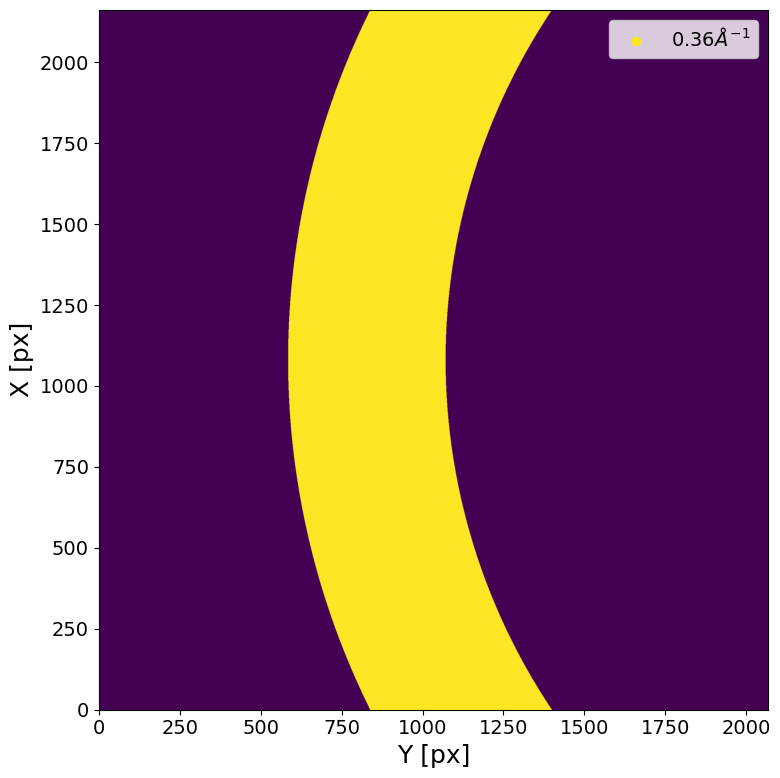

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/6365 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00050.h5 (51/6365 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/6365 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00051.h5 (52/6365 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00052.h5 (53/6365 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/6365 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00053.h5 (54/6365 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00054.h5 (55/6365 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00055.h5 (56/6365 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00056.h5 (57/6365 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00057.h5 (58/6365 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00058.h5 (59/6365 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00059.h5 (60/6365 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00060.h5 (61/6365 loops)
	 -> loading

In [6]:
#######################################
sample_name = 'Ta2O5_2.5um_B'
Ndataset =1
Nscan = 2
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = None, len(scan['fast_timer_period'])-5001
Qmask = XPCS.gen_Qmask(Ei, theta, Q, dq, Qmap_plot=False)
Kossel_mask = np.load(MASKS_folder+'Kossel_mask_Ta2O5_2.5um_asdep_0002_0001.npy')
load_mask = e4m_mask*e4m_htmask*Qmask#*Kossel_mask
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

### Flux check

################################################################################
Maximum count in the whole run -> 5.0
# of pixels above Ith_high treshold ->  314380 pixels (of 4471016 => 7.03 %)
# of pixels below Ith_low treshold ->  577404 pixels (of 4471016 => 12.91 %)
################################################################################



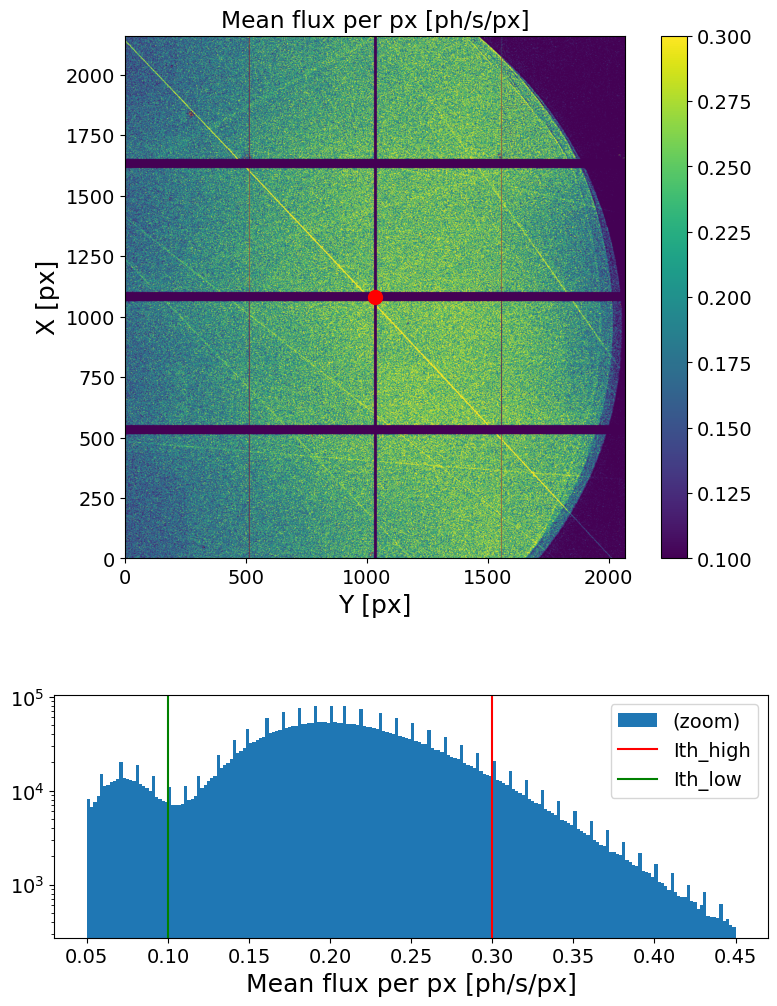

In [76]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_low=0.1, Ith_high=0.3, Nfi=None, Nff=int(1e6), load_mask=load_mask, mask=None)

### Intensity analysis

In [8]:
####################
Lbin = 1000
Nstep = 1000
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)
np.savez(It_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_It=t_It, It=It)

UsageError: Line magic function `%plt.xscale('log')` not found.


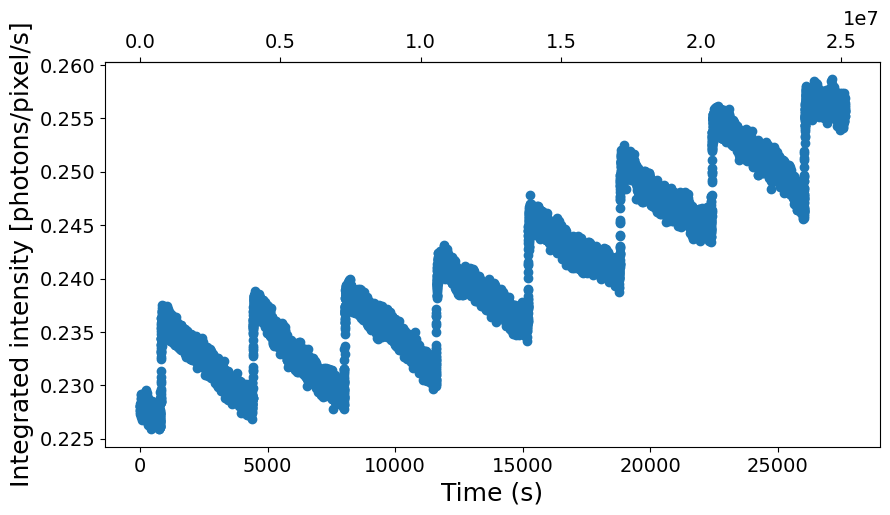

In [9]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
%plt.xscale('log')
plt.show()

### Linear correlation 4 tests

In [7]:
###################
Nfi = None
Nff = None
Lbin = 10000
bin2dense = True
mask = None
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

Loading frames ...
Done! (elapsed time = 0.0 s)
Binning frames (Lbin = 10000, using MKL library) ...
Done! (elapsed time = 72.18 s)
	 | 3182 frames X 872182 pixels
	 | memory usage (np.array @ float32) = 10.339 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 3.76 s)
	 | 3182 X 3182 squared matrix
	 | memory usage (np.array @ float32) = 0.038 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.47 s)



In [11]:
############################
t1, t2 = 0, 15000
vmin, vmax = 1.0, 1.03
############################
#XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=t1, t2=t2, sigma_filter=None)

In [ ]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t_g2, g2, dg2, t_mt, g2_mt, dg2_mt = {}, {}, {}, {}, {}, {}
for n in range(Nbunch):
    if Nfi is None: Nfi = 0
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)

    if Nbunch!=1: t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]))
    else:         t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
    t_mt[t_bunch], g2_mt[t_bunch], dg2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch],dg2[t_bunch])   


Computing g2 (using cython code)...
2.0325117111206055 2.0325114033059393
1.0151267051696777 1.015126737483115
Done! (elapsed time = 0.03 s)



/gpfs/jazzy/data/visitor/hc6211/id10-coh/20250527/SCRIPTS_Trento/XPCSlibrary/XPCS_tools.py:827: RuntimeWarning: invalid value encountered in sqrt
  if    G2t.dtype==np.float32: g2, dg2 = mean_trace_float32(G2t)


Exception ignored in: <function ResourceTracker.__del__ at 0x7cf85b19fce0>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7cf937d83ce0>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", li

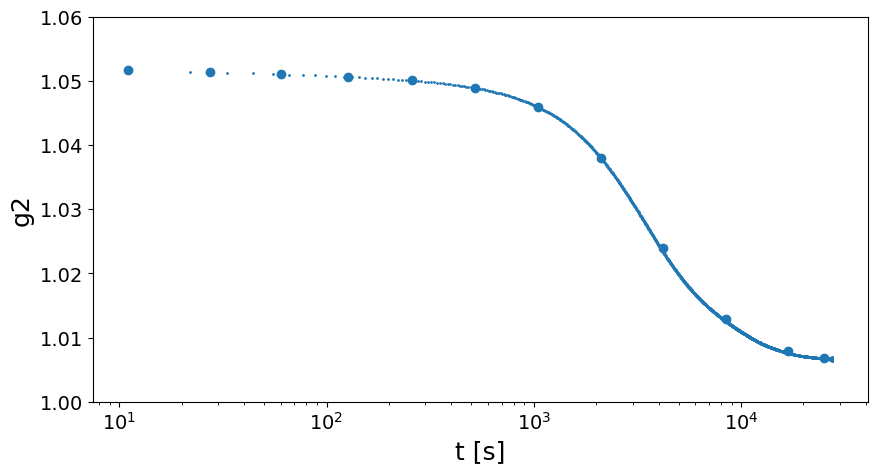

NameError: name 'fit' is not defined

In [17]:
##################
t1_fit = 0
t2_fit = 1e100
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
#params.add('y0', value=1.001, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t_g2[k], g2[k], s=1,  c='C'+str(i), label = str(k)+'s')
    plt.errorbar(t_mt[k], g2_mt[k], yerr = dg2_mt[k],fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    #fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    #g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]


    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    #y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    #plt.plot(x, y, c='C'+str(i), linestyle='--')


plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.06)
#plt.legend()
plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.tight_layout(); plt.show()

### Linear by dose

In [52]:
t_ff = e4m_data.shape[0]*itime
print('#############################')
print('Nff =    =',e4m_data.shape[0], ' =>  t_ff =', t_ff)
print('#############################\n')

#############################
Nff =    = 29313547  =>  t_ff = 32244.901700000002
#############################



In [53]:
########################################
N_segments = 5
t_segments = [0, 13000, 23000, 28000, 32200]#np.linspace(0, int(t_ff), N_segments)
t_skip = [] # skip if Nfi is in t_skip
########################################

Nf_segments = [int (t/itime) for t in t_segments]
Nf_skip = [int(t/itime) for t in t_skip]

In [54]:
from contextlib import redirect_stdout
import io

###################
Lbin = 10000
bin2dense = False
mask = None
###################

t_g2, g2, dg2= {}, {}, {}
for i in tqdm(range(len(Nf_segments)-1)):
    with redirect_stdout(io.StringIO()):
        Nfi = Nf_segments[i]
        Nff = Nf_segments[i+1]
        if not Nfi in Nf_skip:
            G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)
            t_bunch = Nfi*itime + (Nff-Nfi)/2*itime
            t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_g2=t_g2, g2=g2, dg2=dg2)

 50%|█████     | 2/4 [01:57<01:54, 57.25s/it]/gpfs/jazzy/data/visitor/hc6211/id10-coh/20250527/SCRIPTS_Trento/XPCSlibrary/XPCS_tools.py:827: RuntimeWarning: invalid value encountered in sqrt
  if    G2t.dtype==np.float32: g2, dg2 = mean_trace_float32(G2t)
100%|██████████| 4/4 [02:26<00:00, 36.74s/it]


/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects w

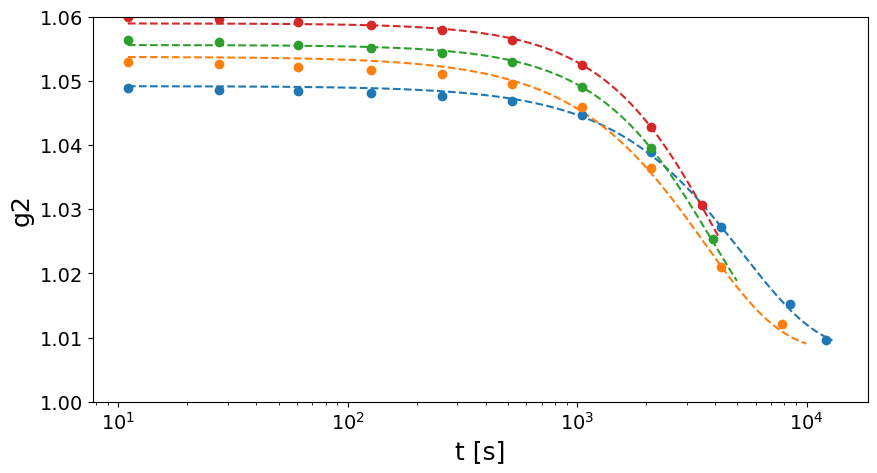

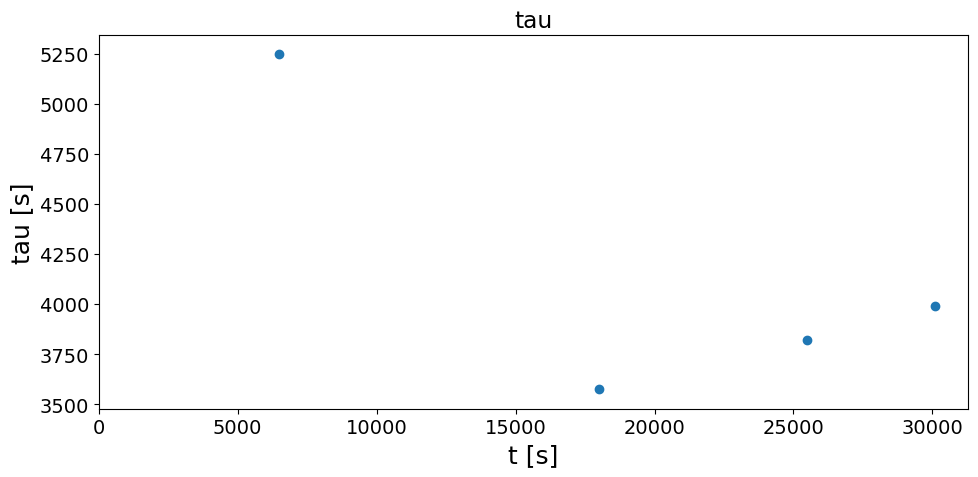

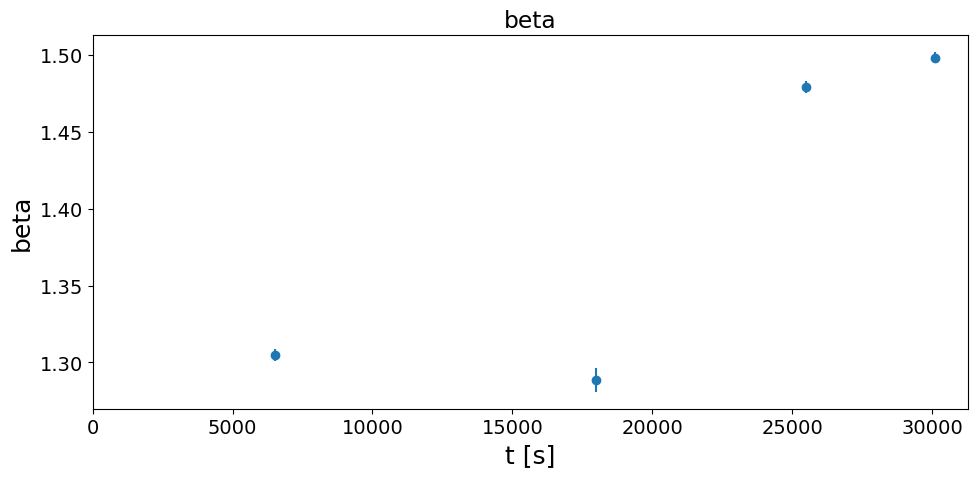

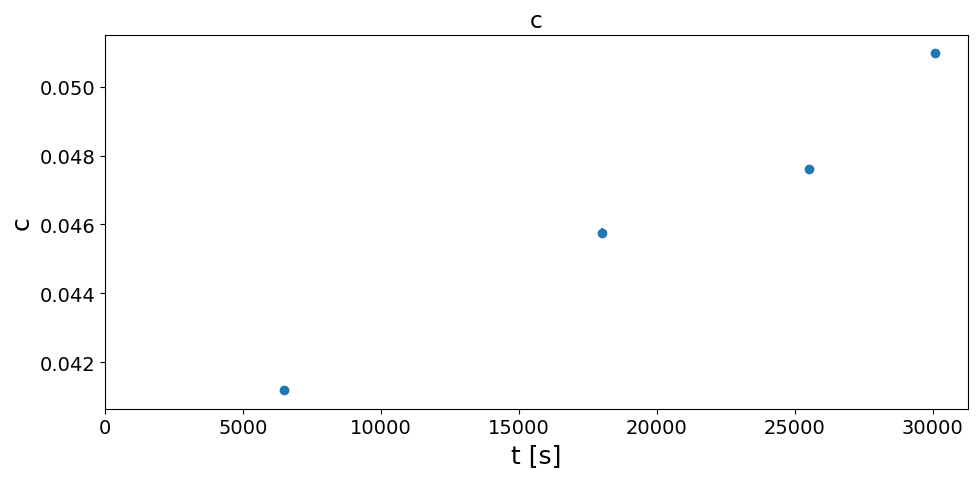

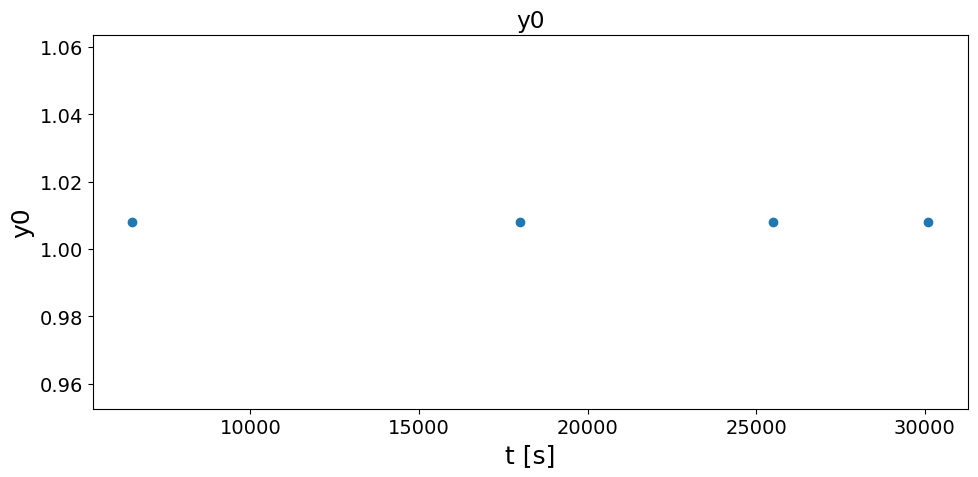

In [72]:
##################
t1_fit = 0
t2_fit = 1e10
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=50, min=0, max=1e6)
params.add('beta', value=0.8, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
#params.add('y0', value=1, min=0, max=2)
params.add('y0', value=1.008, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    #plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares')#, weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

g2_fit.to_csv(g2fit_folder+'g2fit_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.06)
#plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title('tau')
plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('tau [s]')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('beta')
plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('beta')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('c')
plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('c')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('y0')
plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('y0')
plt.tight_layout(); plt.show()

## I(Q) comparison between annealed and as deposited

### Generate Qmask

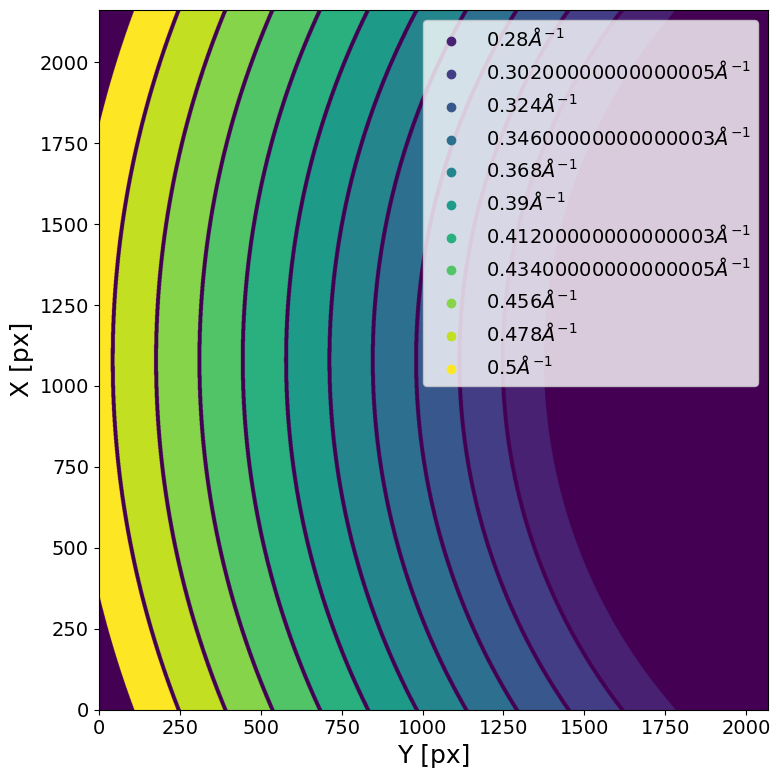

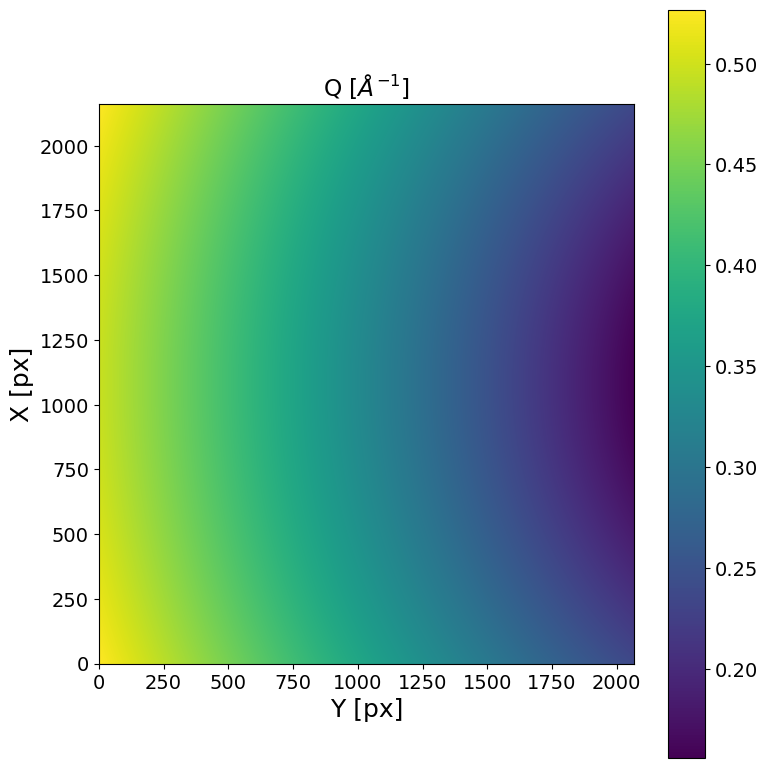

In [ ]:
Q = np.linspace(0.28,0.5,11)
dq = 0.01

Qmask = XPCS.gen_Qmask(Ei, theta, Q, dq, Qmap_plot=False)

### Annealed virgin: XPCS scan: delcoup=1.7, T=4h (Ta2O5_2.5um_B, 1, 2)

In [8]:
#######################################
sample_name = 'Ta2O5_2.5um_B'
Ndataset =1
Nscan = 2
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = None, 16_000_000
Kossel_mask = np.load(MASKS_folder+'Kossel_mask_Ta2O5_2.5um_asdep_0002_0001.npy')
load_mask = None #e4m_mask*e4m_htmask*Qmask#*Kossel_mask
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

#############################
command = mtimescan 0.001 2 86000367
Ei = 21.669991317784486
itime = 0.0011
T =  10.316667166666669 h
theta = 1.6999999999999993
Qc = 0.33
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/3201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00050.h5 (51/3201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/3201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/3201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00051.h5 (52/3201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00052.h5 (53/3201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00053.h5 (54/3201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00054.h5 (55/3201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/3201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00055.h5 (56/3201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00056.h5 (57/3201 loops)
	 -> loading file ei

100%|██████████| 11/11 [01:33<00:00,  8.51s/it]


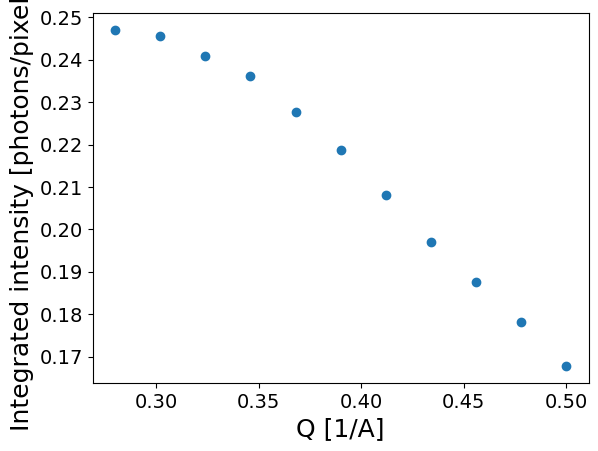

In [ ]:
########################################
Nfi = None
Nff = int(1e6)

mask = e4m_mask*e4m_htmask*Kossel_mask
########################################
if Nfi is None: Nfi = 0
if Nff is None: Nff = e4m_data.shape[0]

Ip_ann = {}
for i in tqdm(list(Qmask.keys())):
    Idt =      e4m_data[Nfi:Nff,mask*Qmask[i]].sum(axis=0)/((Nff-Nfi)*itime)    ######## media temporale
    Ip_ann[i] =      Idt.sum(axis=0)/np.sum(mask*Qmask[i])                      ######## media sui pixel

### Annealed danneggiato: XPCS scan: delcoup=1.7, T=4h (Ta2O5_2.5um_B, 1, 2)

In [32]:
#######################################
sample_name = 'Ta2O5_2.5um_B'
Ndataset =1
Nscan = 2
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = 15_000_000, 16_000_000
Kossel_mask = np.load(MASKS_folder+'Kossel_mask_Ta2O5_2.5um_asdep_0002_0001.npy')
load_mask = None #e4m_mask*e4m_htmask*Qmask#*Kossel_mask
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

#############################
command = mtimescan 0.001 2 86000367
Ei = 21.669991317784486
itime = 0.0011
T =  10.316667166666669 h
theta = 1.6999999999999993
Qc = 0.33
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_03000.h5 (3001/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_03049.h5 (3050/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_03050.h5 (3051/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_03051.h5 (3052/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_03052.h5 (3053/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_03053.h5 (3054/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_03054.h5 (3055/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_03055.h5 (3056/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_03056.h5 (3057/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_03057.h5 (3058/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_03059.h5 (3060/201 loops)
	 -> 

In [33]:
########################################
Nfi = None
Nff = int(1e6)

mask = e4m_mask*e4m_htmask*Kossel_mask
########################################
if Nfi is None: Nfi = 0
if Nff is None: Nff = e4m_data.shape[0]

Ip_ann_damaged = {}
for i in tqdm(list(Qmask.keys())):
    Idt =      e4m_data[Nfi:Nff,mask*Qmask[i]].sum(axis=0)/((Nff-Nfi)*itime)    ######## media temporale
    Ip_ann_damaged[i] =      Idt.sum(axis=0)/np.sum(mask*Qmask[i])                      ######## media sui pixel

100%|██████████| 11/11 [01:38<00:00,  8.93s/it]


### As-deposited virgin: XPCS scan: delcoup=1.7, T=4h (Ta2O5_2.5um_asdep, 4, 5)  

In [13]:
#######################################
sample_name = 'Ta2O5_2.5um_asdep'
Ndataset =4
Nscan = 5
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = None, int(1e6)
Kossel_mask = np.load(MASKS_folder+'Kossel_mask_Ta2O5_2.5um_asdep_0002_0001.npy')
load_mask = None #e4m_mask*e4m_htmask*Qmask*Kossel_mask
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

#############################
command = mtimescan 0.001 1 16000128
Ei = 21.669991317784486
itime = 0.0011
T =  4.888928 h
theta = 1.6999999999999993
Qc = 0.33
#############################

Loading sparse array ...


	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00048.h5 (49/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00049.h5 (50/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00050.h5 (51/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00051.h5 (52/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00052.h5 (53/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00053.h5 (54/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00054.h5 (55/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00055.h5 (56/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00056.h5 (57/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00057.h5 (58/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00058.h5 (59/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00059.h5 (60/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00060.h5 (61/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00061

In [16]:
##############################################
Nfi = None
Nff = int(1e6)

mask = e4m_mask*e4m_htmask*Kossel_mask
##############################################
if Nfi is None: Nfi = 0
if Nff is None: Nff = e4m_data.shape[0]

Ip_asdep = {}
for i in tqdm(list(Qmask.keys())):
    Idt =      e4m_data[Nfi:Nff,mask*Qmask[i]].sum(axis=0)/((Nff-Nfi)*itime)     ######## media temporale
    Ip_asdep[i] =      Idt.sum(axis=0)/np.sum(mask*Qmask[i])                      ######## media sui pixel


100%|██████████| 11/11 [00:39<00:00,  3.58s/it]


### As-deposited danneggiato: XPCS scan: delcoup=1.7, T=4h (Ta2O5_2.5um_asdep, 4, 9)  

In [26]:
#######################################
sample_name = 'Ta2O5_2.5um_asdep'
Ndataset =4
Nscan = 9
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = None, int(1e6)#len(scan['fast_timer_period'])-5001
Kossel_mask = np.load(MASKS_folder+'Kossel_mask_Ta2O5_2.5um_asdep_0002_0001.npy')
load_mask = None # e4m_mask*e4m_htmask#*Qmask*Kossel_mask
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

#############################
command = mtimescan 0.001 2 86000367
Ei = 21.669991317784486
itime = 0.0011
T =  3.3802202500000003 h
theta = 1.6999999999999993
Qc = 0.33
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00049.h5 (50/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00050.h5 (51/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00051.h5 (52/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00052.h5 (53/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00053.h5 (54/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00054.h5 (55/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00056.h5 (57/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00057.h5 (58/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00058.h5 (59/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00059.h5 (60/201 loops)
	 -> loading file eiger4m_v2

In [29]:
##############################################
Nfi = None
Nff = int(1e6)

mask = e4m_mask*e4m_htmask*Kossel_mask
##############################################
if Nfi is None: Nfi = 0
if Nff is None: Nff = e4m_data.shape[0]

Ip_asdep_damaged = {}
for i in tqdm(list(Qmask.keys())):
    Idt =      e4m_data[Nfi:Nff,mask*Qmask[i]].sum(axis=0)/((Nff-Nfi)*itime)     ######## media temporale
    Ip_asdep_damaged[i] =      Idt.sum(axis=0)/np.sum(mask*Qmask[i])                      ######## media sui pixel


100%|██████████| 11/11 [01:47<00:00,  9.76s/it]


### Si substrate: XPCS scan: delcoup=1.7, T=4h (Si_substrate 1, 5)  

In [35]:
#######################################
sample_name = 'Si_substrate'
Ndataset =1
Nscan = 4
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = None, int(1e6) #len(scan['fast_timer_period'])-5001
load_mask = None
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

#############################
command = mtimescan 0.001 2 86000367
Ei = 21.669991317784486
itime = 0.0011
T =  1.3425551944444445 h
theta = 1.6999999999999993
Qc = 0.33
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00019.h5 (20/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00048.h5 (49/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00049.h5 (50/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00050.h5 (51/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00051.h5 (52/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00052.h5 (53/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00053.h5 (54/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00054.h5 (55/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00055.h5 (56/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00056.h5 (57/201 loops)
	 -> loading file eiger4m_v2

In [36]:
##############################################
Nfi = None
Nff = int(1e6)

mask = e4m_mask*e4m_htmask*Kossel_mask
##############################################
if Nfi is None: Nfi = 0
if Nff is None: Nff = e4m_data.shape[0]

Ip_si_virgin = {}
for i in tqdm(list(Qmask.keys())):
    Idt =      e4m_data[Nfi:Nff,mask*Qmask[i]].sum(axis=0)/((Nff-Nfi)*itime)     ######## media temporale
    Ip_si_virgin[i] =      Idt.sum(axis=0)/np.sum(mask*Qmask[i])                      ######## media sui pixel


100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


### Si substrate: XPCS scan: delcoup=1.7, T=4h (Si_substrate 1, 5)  

In [39]:
#######################################
sample_name = 'Si_substrate'
Ndataset =1
Nscan = 4
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = len(scan['fast_timer_period'])-int(1e6), len(scan['fast_timer_period'])
load_mask = None
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

#############################
command = mtimescan 0.001 2 86000367
Ei = 21.669991317784486
itime = 0.0011
T =  1.3425551944444445 h
theta = 1.6999999999999993
Qc = 0.33
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00678.h5 (679/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00679.h5 (680/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00680.h5 (681/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00681.h5 (682/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00682.h5 (683/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00683.h5 (684/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00684.h5 (685/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00685.h5 (686/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00686.h5 (687/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00687.h5 (688/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00688.h5 (689/201 loops)
	 -> loading fil

In [40]:
##############################################
Nfi = None
Nff = int(1e6)

mask = e4m_mask*e4m_htmask*Kossel_mask
##############################################
if Nfi is None: Nfi = 0
if Nff is None: Nff = e4m_data.shape[0]

Ip_si_damaged = {}
for i in tqdm(list(Qmask.keys())):
    Idt =      e4m_data[Nfi:Nff,mask*Qmask[i]].sum(axis=0)/((Nff-Nfi)*itime)     ######## media temporale
    Ip_si_damaged[i] =      Idt.sum(axis=0)/np.sum(mask*Qmask[i])                      ######## media sui pixel


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


### Cfr. between intensities

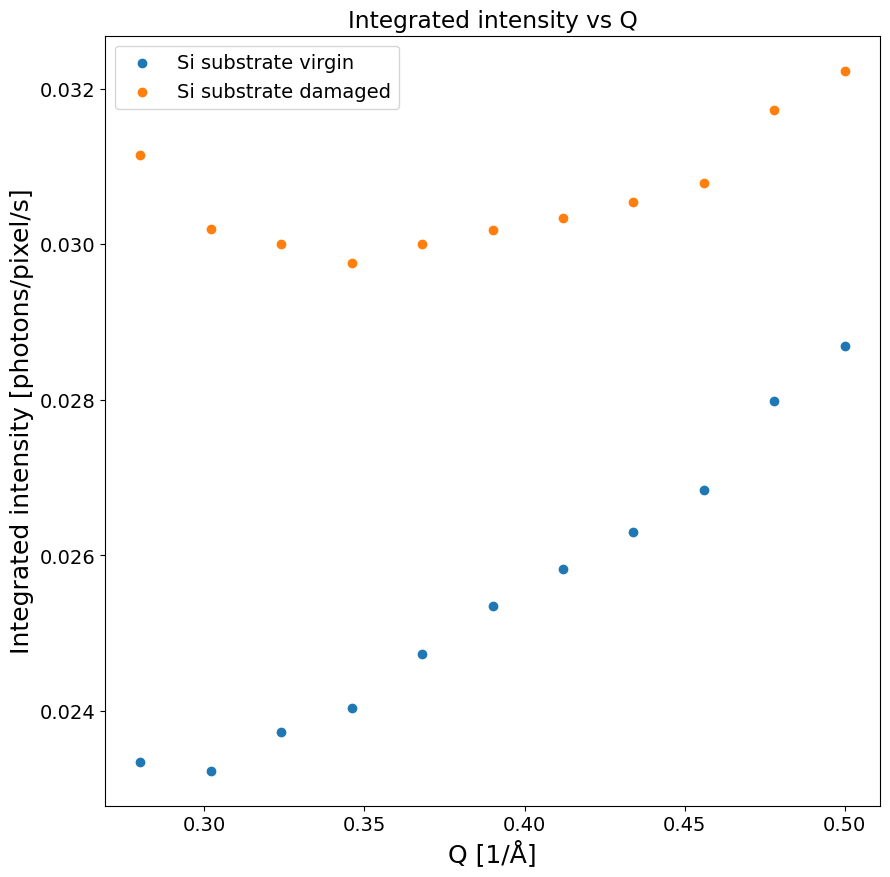

In [48]:
plt.figure(figsize=(10, 10))
'''plt.scatter(Q, Ip_ann.values(),label ='Annealed virgin')
plt.scatter(Q, Ip_ann_damaged.values(), label ='Annealed damaged')
plt.scatter(Q, Ip_asdep.values(), label ='As-deposited virgin')
plt.scatter(Q, Ip_asdep_damaged.values(), label ='As-deposited damaged')'''
plt.scatter(Q, Ip_si_virgin.values(), label ='Si substrate virgin')
plt.scatter(Q, Ip_si_damaged.values(), label ='Si substrate damaged')
#plt.yscale('log')
plt.xlabel('Q [1/Å]')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.title('Integrated intensity vs Q')
plt.legend()
plt.show()